In [113]:
import os
import zipfile
import pandas as pd
import numpy as np
import magic
import os 
import umap
import statistics
from scipy.stats import spearmanr
import harmonypy as hm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
import matplotlib.pyplot as plt
import scanpy as sc
import optuna

Installments
- magic

# Step 0: Download the training data

In [2]:
# get current path 
path_data = os.getcwd() 

### Training data information

In [3]:
bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")

In [4]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453


In [5]:
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")

In [6]:
assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of cells in the train dataset 978


In [7]:
sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")

In [8]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [9]:
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

In [10]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [11]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [12]:
print(f"There are {df.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {df.Celltype.unique()}")

There are 11 different cell types in the dataset
The different cells types are ['delta cell' 'alpha cell' 'beta cell' 'PSC cell' 'endothelial cell'
 'gamma cell' 'co-expression cell' 'ductal cell' 'epsilon cell'
 'unclassified endocrine cell' 'acinar cell']


In [13]:
sc_pancreas_metadata.Celltype.nunique()

13

### Test data information

In [14]:
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [15]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [16]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


Dropout in Single cell data: When a gene is observed at a moderate or high expression level in one cell but not detected in another cell. An expressed transcript is not detected. 
- reasons for dropout: biological, or non-biological. 
- biological: indicates information about cell states
- non-biological: technical zeros, which occur during the preparation of biological samples for sequencing, and sampling zeros, which arise due to limited sequencing depths

Good imputation methods for single cell data
- should achieve: 
1. accurate estimation of missing values
- should avoid: 
1. overfitting or oversmoothing: could lead to loss of biological information or variability 
2. loss of sparsity

Samples  processed by different technicians and/or at different time points could lead to batch effect
- how batch effect may affect single cell data: could lead to variation in sample groups that are caused by technical arrangements rather than biological factors, which could lead to false conclusions 
- methods to overcome potentially confounding effects: eliminate technical noise or bias so that observed variance in gene expression variance primarily reflects true biological variance.
- use some batch correction algorithms: ex: MNN, CCA, Harmony 


# Step 1: Perform the imputation

Methods to try for imputation 
- MAGIC
- ZINB VAE AND ZINB CVAE helps impute dropout effect

- calculating the "bulkified" data means calculating the patient-wide average of gene expression (ex: avg SGIP1 exp for patient1, 2, 3, 4)
- To get the gene expression for patient j, you must simply average the library size-corrected values of the gene expression over all cells of the same patient.
- average spearman's correlation will be calculated for all patients in the test set 

In [17]:
def bulkification(sc_data):
    patient_ids = sorted(list(set([col.split('_')[0] for col in sc_data.columns])))
    bulkified = pd.DataFrame(columns=patient_ids, index=sc_data.index)
    for patient_id in patient_ids:
        # Select columns belonging to the same patient
        patient_columns = [col for col in sc_data.columns if col.startswith(patient_id)]
        patient_data = sc_data[patient_columns]
        
        # Calculate the mean expression for each gene for the current patient
        mean_expression = patient_data.mean(axis=1)
        bulkified[patient_id] = mean_expression
    return bulkified

In [18]:
def calc_spearman(log_transformed_bulk_data, bulkified):
    patient_ids = sorted(list(set([col.split('_')[0] for col in bulkified.columns])))
    spearman_correlations = []
    for patient_id in patient_ids:
        spearman_correlation = spearmanr(log_transformed_bulk_data[patient_id], bulkified[patient_id])[0]
        spearman_correlations.append(spearman_correlation)
    return spearman_correlations

In [25]:
# TODO: findtune parameters for MAGIC, see if you can improve the results, could also do preprocessing (normalization)
magic_operator = magic.MAGIC()
sc_pancreas_imputed = magic_operator.fit_transform(sc_pancreas)


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 64.69 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58687 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 58.52 seconds.
  Calculated graph and diffusion operator in 128.41 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.43 seconds.
Calculated MAGIC in 130.89 seconds.


In [32]:
# bulkifying and calculating spearman correlation
bulkified_train = bulkification(sc_pancreas_imputed)
log_transformed_bulk_data = np.log2(bulk_pancreas + 1)
spearman_correlations = calc_spearman(log_transformed_bulk_data, bulkified_train)
print(statistics.mean(spearman_correlations))

0.9373357756990801


In [114]:
# attempting optimization 
def objective(trial, sc_pancreas, bulk_pancreas):
    # Suggest values for parameters
    knn = trial.suggest_int("knn", 3, 15)
    decay = trial.suggest_float("decay", 1, 10, log=True)
    t = trial.suggest_int("t", 1, 10)
    n_pca = trial.suggest_int("n_pca", 10, 200)

    # Initialize MAGIC with suggested parameters
    magic_operator = magic.MAGIC(
        knn=knn, decay=decay, t=t, n_pca=n_pca
    )

    # Perform imputation
    sc_pancreas_imputed = magic_operator.fit_transform(sc_pancreas)

    # Bulkify and calculate Spearman correlation
    bulkified_train = bulkification(sc_pancreas_imputed)
    log_transformed_bulk_data = np.log2(bulk_pancreas + 1)
    spearman_correlations = calc_spearman(log_transformed_bulk_data, bulkified_train)

    # Return the negative mean Spearman correlation (Optuna minimizes the objective)
    return -statistics.mean(spearman_correlations)

In [115]:
# Create a study and optimize the parameters using Optuna
study = optuna.create_study()
study.optimize(lambda trial: objective(trial, sc_pancreas, bulk_pancreas), n_trials=100)

# Print the best parameters and the corresponding mean Spearman correlation
print("Best parameters:", study.best_params)
print("Best mean Spearman correlation:", -study.best_value)

[I 2023-04-26 01:43:03,611] A new study created in memory with name: no-name-dcd45c95-995e-4bd3-83ff-9d6037f7a1bc


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.79 seconds.
    Calculating KNN search...
    Calculated KNN search in 17.38 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 19.05 seconds.
  Calculated graph and diffusion operator in 40.28 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.84 seconds.
Calculated MAGIC in 41.24 seconds.


[I 2023-04-26 01:43:44,988] Trial 0 finished with value: -0.9407541765277198 and parameters: {'knn': 5, 'decay': 1.6880586833545403, 't': 2, 'n_pca': 41}. Best is trial 0 with value: -0.9407541765277198.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.29 seconds.
    Calculating KNN search...
    Calculated KNN search in 119.88 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 117.91 seconds.
  Calculated graph and diffusion operator in 243.14 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.41 seconds.
Calculated MAGIC in 245.62 seconds.


[I 2023-04-26 01:47:50,733] Trial 1 finished with value: -0.9346336399798305 and parameters: {'knn': 10, 'decay': 1.2440965096014054, 't': 3, 'n_pca': 163}. Best is trial 0 with value: -0.9407541765277198.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.06 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.08 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 7.73 seconds.
  Calculated graph and diffusion operator in 18.92 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 3.87 seconds.
Calculated MAGIC in 22.85 seconds.


[I 2023-04-26 01:48:13,705] Trial 2 finished with value: -0.9400959158640265 and parameters: {'knn': 7, 'decay': 6.323349280539812, 't': 8, 'n_pca': 26}. Best is trial 0 with value: -0.9407541765277198.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.52 seconds.
    Calculating KNN search...
    Calculated KNN search in 80.30 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58687 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 76.74 seconds.
  Calculated graph and diffusion operator in 161.62 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.67 seconds.
Calculated MAGIC in 163.33 seconds.


[I 2023-04-26 01:50:57,165] Trial 3 finished with value: -0.9373633728114289 and parameters: {'knn': 11, 'decay': 6.309985871854108, 't': 2, 'n_pca': 123}. Best is trial 0 with value: -0.9407541765277198.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.50 seconds.
    Calculating KNN search...
    Calculated KNN search in 147.32 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 74485 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 147.71 seconds.
  Calculated graph and diffusion operator in 300.61 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.19 seconds.
Calculated MAGIC in 302.86 seconds.


[I 2023-04-26 01:56:00,159] Trial 4 finished with value: -0.9349097140587816 and parameters: {'knn': 14, 'decay': 3.3328030034562963, 't': 2, 'n_pca': 193}. Best is trial 0 with value: -0.9407541765277198.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.87 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.61 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.64 seconds.
  Calculated graph and diffusion operator in 8.16 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.66 seconds.
Calculated MAGIC in 8.89 seconds.


[I 2023-04-26 01:56:09,176] Trial 5 finished with value: -0.9436082259872091 and parameters: {'knn': 10, 'decay': 1.4178340570993693, 't': 1, 'n_pca': 10}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.11 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.98 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 74485 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.98 seconds.
  Calculated graph and diffusion operator in 13.14 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 8.90 seconds.
Calculated MAGIC in 22.08 seconds.


[I 2023-04-26 01:56:31,387] Trial 6 finished with value: -0.9398718619050731 and parameters: {'knn': 14, 'decay': 3.738384692501154, 't': 10, 'n_pca': 17}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.49 seconds.
    Calculating KNN search...
    Calculated KNN search in 26.00 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 25.08 seconds.
  Calculated graph and diffusion operator in 55.61 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 3.36 seconds.
Calculated MAGIC in 59.01 seconds.


[I 2023-04-26 01:57:30,531] Trial 7 finished with value: -0.9371444496481173 and parameters: {'knn': 5, 'decay': 2.8398460995104124, 't': 9, 'n_pca': 57}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.15 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.63 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 79718 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 5.42 seconds.
  Calculated graph and diffusion operator in 14.25 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 4.76 seconds.
Calculated MAGIC in 19.08 seconds.


[I 2023-04-26 01:57:49,734] Trial 8 finished with value: -0.9411527875278687 and parameters: {'knn': 15, 'decay': 6.354410180337568, 't': 5, 'n_pca': 19}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.03 seconds.
    Calculating KNN search...
    Calculated KNN search in 128.68 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 16331 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 126.53 seconds.
  Calculated graph and diffusion operator in 260.27 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.85 seconds.
Calculated MAGIC in 261.16 seconds.


[I 2023-04-26 02:02:11,024] Trial 9 finished with value: -0.9333109709959063 and parameters: {'knn': 3, 'decay': 2.968603526457265, 't': 3, 'n_pca': 194}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.88 seconds.
    Calculating KNN search...
    Calculated KNN search in 46.41 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 63979 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 439.96 seconds.
  Calculated graph and diffusion operator in 492.32 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 5.03 seconds.
Calculated MAGIC in 497.42 seconds.


[I 2023-04-26 02:10:28,584] Trial 10 finished with value: -0.9360067472418232 and parameters: {'knn': 12, 'decay': 1.0992015711493588, 't': 6, 'n_pca': 84}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.75 seconds.
    Calculating KNN search...
    Calculated KNN search in 36.16 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 79718 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 48.76 seconds.
  Calculated graph and diffusion operator in 90.72 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 5.11 seconds.
Calculated MAGIC in 95.89 seconds.


[I 2023-04-26 02:12:04,612] Trial 11 finished with value: -0.9371559606491867 and parameters: {'knn': 15, 'decay': 9.603463286790399, 't': 5, 'n_pca': 72}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.18 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.69 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.68 seconds.
  Calculated graph and diffusion operator in 7.62 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.48 seconds.
Calculated MAGIC in 10.13 seconds.


[I 2023-04-26 02:12:14,880] Trial 12 finished with value: -0.942660617232666 and parameters: {'knn': 8, 'decay': 1.941564749226454, 't': 5, 'n_pca': 11}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 64.75 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 516.95 seconds.
  Calculated graph and diffusion operator in 585.98 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 4.13 seconds.
Calculated MAGIC in 590.15 seconds.


[I 2023-04-26 02:22:05,176] Trial 13 finished with value: -0.9343110436423738 and parameters: {'knn': 8, 'decay': 1.7913477887324736, 't': 7, 'n_pca': 113}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.20 seconds.
    Calculating KNN search...
    Calculated KNN search in 17.24 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48103 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 17.24 seconds.
  Calculated graph and diffusion operator in 38.73 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.67 seconds.
Calculated MAGIC in 39.46 seconds.


[I 2023-04-26 02:22:44,772] Trial 14 finished with value: -0.9407914901109256 and parameters: {'knn': 9, 'decay': 1.6560254504557759, 't': 1, 'n_pca': 49}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 41.57 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 41.18 seconds.
  Calculated graph and diffusion operator in 88.85 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.07 seconds.
Calculated MAGIC in 90.95 seconds.


[I 2023-04-26 02:24:15,857] Trial 15 finished with value: -0.9373002916628307 and parameters: {'knn': 7, 'decay': 1.0367828987927514, 't': 4, 'n_pca': 84}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.46 seconds.
    Calculating KNN search...
    Calculated KNN search in 634.62 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58687 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 765.44 seconds.
  Calculated graph and diffusion operator in 1404.58 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 5.55 seconds.
Calculated MAGIC in 1410.18 seconds.


[I 2023-04-26 02:47:46,177] Trial 16 finished with value: -0.9330662351513206 and parameters: {'knn': 11, 'decay': 2.1742605195033424, 't': 7, 'n_pca': 138}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 984.58 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48103 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.75 seconds.
  Calculated graph and diffusion operator in 989.74 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.61 seconds.
Calculated MAGIC in 990.41 seconds.


[I 2023-04-26 03:04:16,728] Trial 17 finished with value: -0.9434906435557031 and parameters: {'knn': 9, 'decay': 1.361175907460454, 't': 1, 'n_pca': 11}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.61 seconds.
    Calculating KNN search...
    Calculated KNN search in 11.65 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 63979 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 11.48 seconds.
  Calculated graph and diffusion operator in 27.79 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.85 seconds.
Calculated MAGIC in 28.68 seconds.


[I 2023-04-26 03:04:45,546] Trial 18 finished with value: -0.9410873787441171 and parameters: {'knn': 12, 'decay': 1.3672076546612222, 't': 1, 'n_pca': 37}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 26.67 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 946.18 seconds.
  Calculated graph and diffusion operator in 977.90 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.76 seconds.
Calculated MAGIC in 978.71 seconds.


[I 2023-04-26 03:21:04,399] Trial 19 finished with value: -0.9403907374240363 and parameters: {'knn': 10, 'decay': 1.3562974366498426, 't': 1, 'n_pca': 61}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 47.53 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 47.18 seconds.
  Calculated graph and diffusion operator in 100.99 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.15 seconds.
Calculated MAGIC in 102.20 seconds.


[I 2023-04-26 03:22:46,731] Trial 20 finished with value: -0.9376529462848293 and parameters: {'knn': 5, 'decay': 1.040045420163336, 't': 3, 'n_pca': 93}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.38 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.68 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.69 seconds.
  Calculated graph and diffusion operator in 7.80 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.98 seconds.
Calculated MAGIC in 9.83 seconds.


[I 2023-04-26 03:22:56,702] Trial 21 finished with value: -0.9428479937580936 and parameters: {'knn': 8, 'decay': 2.131736574163314, 't': 4, 'n_pca': 11}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.88 seconds.
    Calculating KNN search...
    Calculated KNN search in 9.04 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48103 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 9.06 seconds.
  Calculated graph and diffusion operator in 22.09 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.43 seconds.
Calculated MAGIC in 24.57 seconds.


[I 2023-04-26 03:23:21,410] Trial 22 finished with value: -0.9403285276431561 and parameters: {'knn': 9, 'decay': 1.4591001052659798, 't': 4, 'n_pca': 30}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.05 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.01 seconds.
  Calculated graph and diffusion operator in 10.77 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.48 seconds.
Calculated MAGIC in 11.28 seconds.


[I 2023-04-26 03:23:32,825] Trial 23 finished with value: -0.9436070857817548 and parameters: {'knn': 7, 'decay': 1.9840170711959781, 't': 1, 'n_pca': 15}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.27 seconds.
    Calculating KNN search...
    Calculated KNN search in 11.34 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 11.42 seconds.
  Calculated graph and diffusion operator in 26.06 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.46 seconds.
Calculated MAGIC in 26.57 seconds.


[I 2023-04-26 03:23:59,524] Trial 24 finished with value: -0.9411860227507319 and parameters: {'knn': 6, 'decay': 1.2789677756033073, 't': 1, 'n_pca': 38}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.46 seconds.
    Calculating KNN search...
    Calculated KNN search in 29.95 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 16331 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 1023.04 seconds.
  Calculated graph and diffusion operator in 1058.48 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.57 seconds.
Calculated MAGIC in 1059.09 seconds.


[I 2023-04-26 03:41:38,752] Trial 25 finished with value: -0.9394524290319816 and parameters: {'knn': 3, 'decay': 1.547911024021979, 't': 2, 'n_pca': 68}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.05 seconds.
    Calculating KNN search...
    Calculated KNN search in 18.50 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 18.51 seconds.
  Calculated graph and diffusion operator in 42.12 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.74 seconds.
Calculated MAGIC in 42.93 seconds.


[I 2023-04-26 03:42:21,825] Trial 26 finished with value: -0.9408116050422473 and parameters: {'knn': 10, 'decay': 2.4426525890450423, 't': 1, 'n_pca': 49}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.53 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.21 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 8.16 seconds.
  Calculated graph and diffusion operator in 19.95 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.02 seconds.
Calculated MAGIC in 21.04 seconds.


[I 2023-04-26 03:42:42,998] Trial 27 finished with value: -0.9412594057306494 and parameters: {'knn': 7, 'decay': 1.8391839785032085, 't': 2, 'n_pca': 28}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.59 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58687 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.59 seconds.
  Calculated graph and diffusion operator in 7.36 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.98 seconds.
Calculated MAGIC in 9.39 seconds.


[I 2023-04-26 03:42:52,517] Trial 28 finished with value: -0.9429266961913365 and parameters: {'knn': 11, 'decay': 1.5293926269342886, 't': 3, 'n_pca': 10}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.37 seconds.
    Calculating KNN search...
    Calculated KNN search in 17.51 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 248.04 seconds.
  Calculated graph and diffusion operator in 269.99 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.92 seconds.
Calculated MAGIC in 270.95 seconds.


[I 2023-04-26 03:47:23,609] Trial 29 finished with value: -0.9402037048693328 and parameters: {'knn': 6, 'decay': 1.632124711474055, 't': 2, 'n_pca': 49}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.39 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.68 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 21643 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 10.40 seconds.
  Calculated graph and diffusion operator in 24.53 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.35 seconds.
Calculated MAGIC in 24.95 seconds.


[I 2023-04-26 03:47:48,691] Trial 30 finished with value: -0.9412846762618576 and parameters: {'knn': 4, 'decay': 1.202880594157578, 't': 1, 'n_pca': 36}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.63 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 63979 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.65 seconds.
  Calculated graph and diffusion operator in 7.43 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.17 seconds.
Calculated MAGIC in 9.64 seconds.


[I 2023-04-26 03:47:58,462] Trial 31 finished with value: -0.9428754345385533 and parameters: {'knn': 12, 'decay': 1.5169268185859284, 't': 3, 'n_pca': 10}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 992.89 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.80 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48103 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 8.09 seconds.
  Calculated graph and diffusion operator in 1008.82 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.28 seconds.
Calculated MAGIC in 1010.15 seconds.


[I 2023-04-26 04:04:48,752] Trial 32 finished with value: -0.9415397041132307 and parameters: {'knn': 9, 'decay': 1.1963862951576483, 't': 2, 'n_pca': 24}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.29 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58687 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 7.56 seconds.
  Calculated graph and diffusion operator in 18.51 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.19 seconds.
Calculated MAGIC in 20.76 seconds.


[I 2023-04-26 04:05:09,650] Trial 33 finished with value: -0.9411514499781568 and parameters: {'knn': 11, 'decay': 1.4136092118476635, 't': 3, 'n_pca': 24}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.37 seconds.
    Calculating KNN search...
    Calculated KNN search in 14.51 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 301.31 seconds.
  Calculated graph and diffusion operator in 320.26 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.79 seconds.
Calculated MAGIC in 321.10 seconds.


[I 2023-04-26 04:10:30,895] Trial 34 finished with value: -0.9410183132862855 and parameters: {'knn': 10, 'decay': 1.7233706533921724, 't': 1, 'n_pca': 44}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.03 seconds.
    Calculating KNN search...
    Calculated KNN search in 482.15 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 69251 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 984.55 seconds.
  Calculated graph and diffusion operator in 1471.80 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.88 seconds.
Calculated MAGIC in 1474.72 seconds.


[I 2023-04-26 04:35:05,749] Trial 35 finished with value: -0.9354985711898836 and parameters: {'knn': 13, 'decay': 1.1655042891760952, 't': 3, 'n_pca': 145}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.70 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.51 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58687 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 5.53 seconds.
  Calculated graph and diffusion operator in 13.79 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.46 seconds.
Calculated MAGIC in 15.31 seconds.


[I 2023-04-26 04:35:21,202] Trial 36 finished with value: -0.9419346308948462 and parameters: {'knn': 11, 'decay': 1.302227338245702, 't': 2, 'n_pca': 20}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.71 seconds.
    Calculating KNN search...
    Calculated KNN search in 116.60 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48103 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 1915.58 seconds.
  Calculated graph and diffusion operator in 2036.95 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.42 seconds.
Calculated MAGIC in 2038.42 seconds.


[I 2023-04-26 05:09:19,806] Trial 37 finished with value: -0.9350989832841424 and parameters: {'knn': 9, 'decay': 1.0000823847210076, 't': 2, 'n_pca': 179}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 901.27 seconds.
    Calculating KNN search...
    Calculated KNN search in 11.07 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 9.79 seconds.
  Calculated graph and diffusion operator in 922.18 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.73 seconds.
Calculated MAGIC in 923.97 seconds.


[I 2023-04-26 05:24:43,922] Trial 38 finished with value: -0.9404717594822474 and parameters: {'knn': 6, 'decay': 2.0271149342408425, 't': 4, 'n_pca': 32}. Best is trial 5 with value: -0.9436082259872091.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.57 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.44 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.40 seconds.
  Calculated graph and diffusion operator in 7.44 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.48 seconds.
Calculated MAGIC in 7.99 seconds.


[I 2023-04-26 05:24:52,044] Trial 39 finished with value: -0.9437175596942341 and parameters: {'knn': 7, 'decay': 2.387336394605383, 't': 1, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.77 seconds.
    Calculating KNN search...
    Calculated KNN search in 24.44 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 23.55 seconds.
  Calculated graph and diffusion operator in 52.82 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.56 seconds.
Calculated MAGIC in 53.42 seconds.


[I 2023-04-26 05:25:45,601] Trial 40 finished with value: -0.9406367630346975 and parameters: {'knn': 7, 'decay': 2.424595757136908, 't': 1, 'n_pca': 56}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.82 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.94 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.87 seconds.
  Calculated graph and diffusion operator in 12.67 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.08 seconds.
Calculated MAGIC in 13.80 seconds.


[I 2023-04-26 05:25:59,532] Trial 41 finished with value: -0.9420119727879861 and parameters: {'knn': 8, 'decay': 1.7425588207135663, 't': 2, 'n_pca': 18}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.53 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.57 seconds.
  Calculated graph and diffusion operator in 7.34 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.62 seconds.
Calculated MAGIC in 7.99 seconds.


[I 2023-04-26 05:26:07,654] Trial 42 finished with value: -0.9436126700889932 and parameters: {'knn': 10, 'decay': 1.5101804226081232, 't': 1, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.57 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.37 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 6.34 seconds.
  Calculated graph and diffusion operator in 15.36 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.72 seconds.
Calculated MAGIC in 16.12 seconds.


[I 2023-04-26 05:26:23,905] Trial 43 finished with value: -0.9419402546443478 and parameters: {'knn': 10, 'decay': 1.9400360556257903, 't': 1, 'n_pca': 22}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.94 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.91 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 8.86 seconds.
  Calculated graph and diffusion operator in 21.75 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 5.35 seconds.
Calculated MAGIC in 27.13 seconds.


[I 2023-04-26 05:26:51,168] Trial 44 finished with value: -0.9386344809889213 and parameters: {'knn': 8, 'decay': 2.551300662010297, 't': 10, 'n_pca': 30}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.66 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.51 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.50 seconds.
  Calculated graph and diffusion operator in 11.72 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 4.01 seconds.
Calculated MAGIC in 15.77 seconds.


[I 2023-04-26 05:27:07,069] Trial 45 finished with value: -0.9409604856790833 and parameters: {'knn': 7, 'decay': 2.2114711077420606, 't': 9, 'n_pca': 17}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 912.72 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48103 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 14.70 seconds.
  Calculated graph and diffusion operator in 931.14 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.35 seconds.
Calculated MAGIC in 932.53 seconds.


[I 2023-04-26 05:42:39,734] Trial 46 finished with value: -0.9405017587267694 and parameters: {'knn': 9, 'decay': 1.876817009253578, 't': 2, 'n_pca': 43}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.80 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.16 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 21643 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.06 seconds.
  Calculated graph and diffusion operator in 11.06 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.32 seconds.
Calculated MAGIC in 11.45 seconds.


[I 2023-04-26 05:42:51,321] Trial 47 finished with value: -0.9429930983594416 and parameters: {'knn': 4, 'decay': 1.6038722748926733, 't': 1, 'n_pca': 16}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.99 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 53395 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 906.44 seconds.
  Calculated graph and diffusion operator in 917.57 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.75 seconds.
Calculated MAGIC in 918.36 seconds.


[I 2023-04-26 05:58:09,849] Trial 48 finished with value: -0.9415405048303291 and parameters: {'knn': 10, 'decay': 3.2764710476078625, 't': 1, 'n_pca': 27}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.70 seconds.
    Calculating KNN search...
    Calculated KNN search in 973.45 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 59.43 seconds.
  Calculated graph and diffusion operator in 1037.63 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 3.51 seconds.
Calculated MAGIC in 1041.21 seconds.


[I 2023-04-26 06:15:31,200] Trial 49 finished with value: -0.9349213122852276 and parameters: {'knn': 8, 'decay': 1.3435226213942804, 't': 6, 'n_pca': 112}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.95 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.48 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.38 seconds.
  Calculated graph and diffusion operator in 6.85 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.42 seconds.
Calculated MAGIC in 7.35 seconds.


[I 2023-04-26 06:15:38,689] Trial 50 finished with value: -0.9437104442480384 and parameters: {'knn': 6, 'decay': 1.1669918723717645, 't': 1, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.34 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.36 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.36 seconds.
  Calculated graph and diffusion operator in 7.11 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.42 seconds.
Calculated MAGIC in 7.57 seconds.


[I 2023-04-26 06:15:46,385] Trial 51 finished with value: -0.9437111156554189 and parameters: {'knn': 6, 'decay': 1.1839976425468908, 't': 1, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.78 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.70 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.67 seconds.
  Calculated graph and diffusion operator in 12.18 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.38 seconds.
Calculated MAGIC in 12.60 seconds.


[I 2023-04-26 06:15:59,118] Trial 52 finished with value: -0.9421558684859995 and parameters: {'knn': 5, 'decay': 1.1488322745106085, 't': 1, 'n_pca': 18}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.99 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.37 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.35 seconds.
  Calculated graph and diffusion operator in 6.75 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.77 seconds.
Calculated MAGIC in 7.55 seconds.


[I 2023-04-26 06:16:06,803] Trial 53 finished with value: -0.9434846484645416 and parameters: {'knn': 6, 'decay': 1.2563486312812195, 't': 2, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.43 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 21643 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 10.42 seconds.
  Calculated graph and diffusion operator in 24.16 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.35 seconds.
Calculated MAGIC in 24.55 seconds.


[I 2023-04-26 06:16:31,491] Trial 54 finished with value: -0.9412565713054772 and parameters: {'knn': 4, 'decay': 1.0881665090235082, 't': 1, 'n_pca': 36}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.03 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.99 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 6.91 seconds.
  Calculated graph and diffusion operator in 16.96 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.85 seconds.
Calculated MAGIC in 17.85 seconds.


[I 2023-04-26 06:16:49,475] Trial 55 finished with value: -0.9416867828634441 and parameters: {'knn': 6, 'decay': 1.4753150576000924, 't': 2, 'n_pca': 24}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.84 seconds.
    Calculating KNN search...
    Calculated KNN search in 9.28 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 10.07 seconds.
  Calculated graph and diffusion operator in 22.25 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.55 seconds.
Calculated MAGIC in 22.86 seconds.


[I 2023-04-26 06:17:12,480] Trial 56 finished with value: -0.9413497605296544 and parameters: {'knn': 7, 'decay': 1.1026691413448748, 't': 1, 'n_pca': 32}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.87 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.11 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.12 seconds.
  Calculated graph and diffusion operator in 11.17 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.07 seconds.
Calculated MAGIC in 12.31 seconds.


[I 2023-04-26 06:17:24,923] Trial 57 finished with value: -0.9426520282366716 and parameters: {'knn': 5, 'decay': 1.710548539237151, 't': 3, 'n_pca': 16}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 1010.43 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 13.64 seconds.
  Calculated graph and diffusion operator in 1028.13 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.02 seconds.
Calculated MAGIC in 1029.18 seconds.


[I 2023-04-26 06:34:34,245] Trial 58 finished with value: -0.94058383277139 and parameters: {'knn': 7, 'decay': 1.43315304844433, 't': 2, 'n_pca': 42}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.66 seconds.
    Calculating KNN search...
    Calculated KNN search in 26.37 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 27.11 seconds.
  Calculated graph and diffusion operator in 59.17 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.47 seconds.
Calculated MAGIC in 59.71 seconds.


[I 2023-04-26 06:35:34,096] Trial 59 finished with value: -0.9404135776331175 and parameters: {'knn': 5, 'decay': 1.2443508433510824, 't': 1, 'n_pca': 61}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.26 seconds.
    Calculating KNN search...
    Calculated KNN search in 48.05 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 1044.53 seconds.
  Calculated graph and diffusion operator in 1098.89 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.97 seconds.
Calculated MAGIC in 1099.90 seconds.


[I 2023-04-26 06:53:54,172] Trial 60 finished with value: -0.9382506468274533 and parameters: {'knn': 6, 'decay': 1.5784048618414026, 't': 2, 'n_pca': 96}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.82 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 3.79 seconds.
  Calculated graph and diffusion operator in 10.92 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.55 seconds.
Calculated MAGIC in 11.53 seconds.


[I 2023-04-26 06:54:05,840] Trial 61 finished with value: -0.9436046431353683 and parameters: {'knn': 8, 'decay': 1.349487294368618, 't': 1, 'n_pca': 14}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.61 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.13 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.06 seconds.
  Calculated graph and diffusion operator in 10.85 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.55 seconds.
Calculated MAGIC in 11.43 seconds.


[I 2023-04-26 06:54:17,405] Trial 62 finished with value: -0.9435575432779053 and parameters: {'knn': 8, 'decay': 1.324451641842918, 't': 1, 'n_pca': 15}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.27 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.68 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 42811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 6.70 seconds.
  Calculated graph and diffusion operator in 16.70 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.56 seconds.
Calculated MAGIC in 17.31 seconds.


[I 2023-04-26 06:54:34,848] Trial 63 finished with value: -0.9418857970656425 and parameters: {'knn': 8, 'decay': 1.0965496815956564, 't': 1, 'n_pca': 23}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.40 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.41 seconds.
  Calculated graph and diffusion operator in 7.19 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.47 seconds.
Calculated MAGIC in 7.70 seconds.


[I 2023-04-26 06:54:42,686] Trial 64 finished with value: -0.9436941367381649 and parameters: {'knn': 7, 'decay': 1.445440496845327, 't': 1, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.43 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.43 seconds.
  Calculated graph and diffusion operator in 6.91 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.93 seconds.
Calculated MAGIC in 7.89 seconds.


[I 2023-04-26 06:54:50,707] Trial 65 finished with value: -0.9434520352278473 and parameters: {'knn': 7, 'decay': 1.813235957466144, 't': 2, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.39 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.40 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 8.27 seconds.
  Calculated graph and diffusion operator in 20.10 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.89 seconds.
Calculated MAGIC in 23.03 seconds.


[I 2023-04-26 06:55:13,869] Trial 66 finished with value: -0.9398537578780161 and parameters: {'knn': 6, 'decay': 1.4805956112348448, 't': 7, 'n_pca': 29}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.43 seconds.
    Calculating KNN search...
    Calculated KNN search in 1045.95 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 76.30 seconds.
  Calculated graph and diffusion operator in 1126.73 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.66 seconds.
Calculated MAGIC in 1127.44 seconds.


[I 2023-04-26 07:14:01,444] Trial 67 finished with value: -0.9378806117528176 and parameters: {'knn': 7, 'decay': 1.2155455568275468, 't': 1, 'n_pca': 135}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.51 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.63 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 63979 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 5.63 seconds.
  Calculated graph and diffusion operator in 13.83 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.80 seconds.
Calculated MAGIC in 14.71 seconds.


[I 2023-04-26 07:14:16,287] Trial 68 finished with value: -0.9421438923168977 and parameters: {'knn': 12, 'decay': 1.58181365764676, 't': 1, 'n_pca': 20}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.48 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.98 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48103 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 11.11 seconds.
  Calculated graph and diffusion operator in 25.62 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.28 seconds.
Calculated MAGIC in 26.94 seconds.


[I 2023-04-26 07:14:43,356] Trial 69 finished with value: -0.9407827965834505 and parameters: {'knn': 9, 'decay': 1.657739568677738, 't': 2, 'n_pca': 36}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.72 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.79 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 21643 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 6.74 seconds.
  Calculated graph and diffusion operator in 16.29 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.60 seconds.
Calculated MAGIC in 16.92 seconds.


[I 2023-04-26 07:15:00,403] Trial 70 finished with value: -0.9418186544542837 and parameters: {'knn': 4, 'decay': 1.4268155979830783, 't': 2, 'n_pca': 24}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.74 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.98 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 3.98 seconds.
  Calculated graph and diffusion operator in 10.76 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.47 seconds.
Calculated MAGIC in 11.27 seconds.


[I 2023-04-26 07:15:11,805] Trial 71 finished with value: -0.9435841763018563 and parameters: {'knn': 7, 'decay': 1.3522891607965288, 't': 1, 'n_pca': 15}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.01 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.36 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.33 seconds.
  Calculated graph and diffusion operator in 6.73 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.41 seconds.
Calculated MAGIC in 7.18 seconds.


[I 2023-04-26 07:15:19,118] Trial 72 finished with value: -0.9437141825781161 and parameters: {'knn': 6, 'decay': 1.264462070202, 't': 1, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.74 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.38 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.35 seconds.
  Calculated graph and diffusion operator in 6.51 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.42 seconds.
Calculated MAGIC in 6.97 seconds.


[I 2023-04-26 07:15:26,221] Trial 73 finished with value: -0.9437105281101289 and parameters: {'knn': 6, 'decay': 1.1720677044130083, 't': 1, 'n_pca': 10}. Best is trial 39 with value: -0.9437175596942341.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.87 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.30 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.30 seconds.
  Calculated graph and diffusion operator in 6.52 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.34 seconds.
Calculated MAGIC in 6.90 seconds.


[I 2023-04-26 07:15:33,258] Trial 74 finished with value: -0.9437305855921146 and parameters: {'knn': 5, 'decay': 1.005341402879557, 't': 1, 'n_pca': 10}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.81 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.42 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.38 seconds.
  Calculated graph and diffusion operator in 6.65 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.43 seconds.
Calculated MAGIC in 7.12 seconds.


[I 2023-04-26 07:15:40,521] Trial 75 finished with value: -0.9437046060461275 and parameters: {'knn': 6, 'decay': 1.036592676796053, 't': 1, 'n_pca': 10}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 955.32 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.68 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 5.68 seconds.
  Calculated graph and diffusion operator in 966.73 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.47 seconds.
Calculated MAGIC in 967.24 seconds.


[I 2023-04-26 07:31:47,898] Trial 76 finished with value: -0.9420928730752349 and parameters: {'knn': 6, 'decay': 1.0199708477647367, 't': 1, 'n_pca': 21}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.11 seconds.
    Calculating KNN search...
    Calculated KNN search in 9.32 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 9.12 seconds.
  Calculated graph and diffusion operator in 21.59 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.75 seconds.
Calculated MAGIC in 22.41 seconds.


[I 2023-04-26 07:32:10,440] Trial 77 finished with value: -0.9410974365061144 and parameters: {'knn': 5, 'decay': 1.1518611572481559, 't': 2, 'n_pca': 32}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.94 seconds.
    Calculating KNN search...
    Calculated KNN search in 1038.58 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 8.19 seconds.
  Calculated graph and diffusion operator in 1049.76 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.46 seconds.
Calculated MAGIC in 1050.25 seconds.


[I 2023-04-26 07:49:40,830] Trial 78 finished with value: -0.9415250829669806 and parameters: {'knn': 6, 'decay': 1.0034132468543993, 't': 1, 'n_pca': 27}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 37.76 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 583.54 seconds.
  Calculated graph and diffusion operator in 627.40 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 3.23 seconds.
Calculated MAGIC in 630.71 seconds.


[I 2023-04-26 08:00:11,731] Trial 79 finished with value: -0.9358215335073561 and parameters: {'knn': 5, 'decay': 1.0515223050802718, 't': 8, 'n_pca': 79}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.11 seconds.
    Calculating KNN search...
    Calculated KNN search in 535.20 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 21643 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 109.17 seconds.
  Calculated graph and diffusion operator in 649.52 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.76 seconds.
Calculated MAGIC in 650.36 seconds.


[I 2023-04-26 08:11:02,228] Trial 80 finished with value: -0.9357493932870998 and parameters: {'knn': 4, 'decay': 1.1281627523677749, 't': 2, 'n_pca': 158}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.34 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.35 seconds.
  Calculated graph and diffusion operator in 6.94 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.41 seconds.
Calculated MAGIC in 7.42 seconds.


[I 2023-04-26 08:11:09,782] Trial 81 finished with value: -0.9437137251146892 and parameters: {'knn': 6, 'decay': 1.2527267483637585, 't': 1, 'n_pca': 10}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.67 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 45.64 seconds.
  Calculated graph and diffusion operator in 52.01 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.45 seconds.
Calculated MAGIC in 52.50 seconds.


[I 2023-04-26 08:12:02,417] Trial 82 finished with value: -0.9437028811908716 and parameters: {'knn': 6, 'decay': 1.1972307238148372, 't': 1, 'n_pca': 14}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.62 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.16 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 5.16 seconds.
  Calculated graph and diffusion operator in 13.00 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.38 seconds.
Calculated MAGIC in 13.42 seconds.


[I 2023-04-26 08:12:15,971] Trial 83 finished with value: -0.9421847599943589 and parameters: {'knn': 5, 'decay': 1.2370483272663793, 't': 1, 'n_pca': 20}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.68 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 3.67 seconds.
  Calculated graph and diffusion operator in 9.61 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.41 seconds.
Calculated MAGIC in 10.06 seconds.


[I 2023-04-26 08:12:26,159] Trial 84 finished with value: -0.9437018836289108 and parameters: {'knn': 6, 'decay': 1.1752008510850405, 't': 1, 'n_pca': 14}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.55 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.86 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 3.87 seconds.
  Calculated graph and diffusion operator in 10.33 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.69 seconds.
Calculated MAGIC in 11.05 seconds.


[I 2023-04-26 08:12:37,337] Trial 85 finished with value: -0.9433315369304305 and parameters: {'knn': 5, 'decay': 1.0691002343315024, 't': 2, 'n_pca': 15}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.82 seconds.
    Calculating KNN search...
    Calculated KNN search in 41.52 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 7.53 seconds.
  Calculated graph and diffusion operator in 51.91 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.46 seconds.
Calculated MAGIC in 52.41 seconds.


[I 2023-04-26 08:13:29,883] Trial 86 finished with value: -0.9415203640781471 and parameters: {'knn': 6, 'decay': 1.2710154833234062, 't': 1, 'n_pca': 26}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.21 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 5.21 seconds.
  Calculated graph and diffusion operator in 13.12 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 2.01 seconds.
Calculated MAGIC in 15.17 seconds.


[I 2023-04-26 08:13:45,199] Trial 87 finished with value: -0.9415875949599259 and parameters: {'knn': 6, 'decay': 1.0685054096506095, 't': 5, 'n_pca': 20}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.88 seconds.
    Calculating KNN search...
    Calculated KNN search in 11.38 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 16331 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 77.27 seconds.
  Calculated graph and diffusion operator in 92.56 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.28 seconds.
Calculated MAGIC in 92.88 seconds.


[I 2023-04-26 08:15:18,209] Trial 88 finished with value: -0.9410789016722583 and parameters: {'knn': 3, 'decay': 1.1867282854852705, 't': 1, 'n_pca': 39}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 9.36 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 9.43 seconds.
  Calculated graph and diffusion operator in 21.83 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.76 seconds.
Calculated MAGIC in 22.64 seconds.


[I 2023-04-26 08:15:40,991] Trial 89 finished with value: -0.9411175944927618 and parameters: {'knn': 5, 'decay': 1.107691712414437, 't': 2, 'n_pca': 32}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.96 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.76 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 3.71 seconds.
  Calculated graph and diffusion operator in 10.47 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.44 seconds.
Calculated MAGIC in 10.95 seconds.


[I 2023-04-26 08:15:52,075] Trial 90 finished with value: -0.9437058889016283 and parameters: {'knn': 6, 'decay': 1.2793173892176986, 't': 1, 'n_pca': 14}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.39 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.68 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 16.89 seconds.
  Calculated graph and diffusion operator in 23.02 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.47 seconds.
Calculated MAGIC in 23.53 seconds.


[I 2023-04-26 08:16:15,743] Trial 91 finished with value: -0.9437049768912078 and parameters: {'knn': 6, 'decay': 1.256090055269031, 't': 1, 'n_pca': 14}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.38 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.35 seconds.
  Calculated graph and diffusion operator in 6.85 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.40 seconds.
Calculated MAGIC in 7.29 seconds.


[I 2023-04-26 08:16:23,158] Trial 92 finished with value: -0.9437150583584228 and parameters: {'knn': 6, 'decay': 1.284962218420144, 't': 1, 'n_pca': 10}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.50 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.02 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.93 seconds.
  Calculated graph and diffusion operator in 12.49 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.38 seconds.
Calculated MAGIC in 12.90 seconds.


[I 2023-04-26 08:16:36,195] Trial 93 finished with value: -0.9420921673809648 and parameters: {'knn': 5, 'decay': 1.2838154005014109, 't': 1, 'n_pca': 19}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.03 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.99 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 6.93 seconds.
  Calculated graph and diffusion operator in 17.00 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.83 seconds.
Calculated MAGIC in 17.87 seconds.


[I 2023-04-26 08:16:54,198] Trial 94 finished with value: -0.9416709573371962 and parameters: {'knn': 6, 'decay': 1.2891541146879941, 't': 2, 'n_pca': 24}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.45 seconds.
    Calculating KNN search...
    Calculated KNN search in 88.34 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 21643 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 3.56 seconds.
  Calculated graph and diffusion operator in 94.41 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.33 seconds.
Calculated MAGIC in 94.77 seconds.


[I 2023-04-26 08:18:29,109] Trial 95 finished with value: -0.9436856299033489 and parameters: {'knn': 4, 'decay': 1.4039573082432693, 't': 1, 'n_pca': 14}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.90 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.82 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 37519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 4.79 seconds.
  Calculated graph and diffusion operator in 12.56 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.48 seconds.
Calculated MAGIC in 13.09 seconds.


[I 2023-04-26 08:18:42,330] Trial 96 finished with value: -0.9421330609664033 and parameters: {'knn': 7, 'decay': 1.1302202209874612, 't': 1, 'n_pca': 18}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.07 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 8.05 seconds.
  Calculated graph and diffusion operator in 19.39 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.85 seconds.
Calculated MAGIC in 20.29 seconds.


[I 2023-04-26 08:19:02,751] Trial 97 finished with value: -0.9412802579702915 and parameters: {'knn': 6, 'decay': 1.2202503025821196, 't': 2, 'n_pca': 28}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.63 seconds.
    Calculating KNN search...
    Calculated KNN search in 349.88 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 229.62 seconds.
  Calculated graph and diffusion operator in 584.17 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.52 seconds.
Calculated MAGIC in 584.73 seconds.


[I 2023-04-26 08:28:47,622] Trial 98 finished with value: -0.9354936659597431 and parameters: {'knn': 5, 'decay': 1.3761833646370438, 't': 1, 'n_pca': 199}. Best is trial 74 with value: -0.9437305855921146.


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.44 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.22 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 32227 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 92.71 seconds.
  Calculated graph and diffusion operator in 98.42 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 0.47 seconds.
Calculated MAGIC in 98.95 seconds.


[I 2023-04-26 08:30:26,719] Trial 99 finished with value: -0.9436878741508574 and parameters: {'knn': 6, 'decay': 1.3158118424608043, 't': 1, 'n_pca': 13}. Best is trial 74 with value: -0.9437305855921146.


Best parameters: {'knn': 5, 'decay': 1.005341402879557, 't': 1, 'n_pca': 10}
Best mean Spearman correlation: 0.9437305855921146


# Step 2: Perform clustering 

- clustering output can be performed on raw/imputed counts
- free to do whatever transformations on data

Batch correction methods
- regression based methods (ComBat)
- dimensionality reduction methods (Harmony, Seurat, iNMF)
- deep learning based models (BERMUDA, scVI, scVAE)

--> trying out LIGER, Harmony, Seurat 

### Parameters that could be tuned
- which preprocessing pipeline to use 
- whether to include harmony batch correction or not 
- which leiden resolution to use to obtain clusters

In [101]:
# calcluating scores 
def cluster_scoring(adata, leiden_res, sc_metadata):
    labels = adata.obs[leiden_res]
    ari = adjusted_rand_score(sc_metadata.Celltype, labels)
    v_measure = v_measure_score(sc_metadata.Celltype, labels)
    # TODO: not sure if ssc is accurate 
    ssc = silhouette_score(adata.obsm["X_pca"], labels)
    avg = (ari + v_measure + ssc)/3
    print(f"resolution: {leiden_res}, ARI: {ari}, V-measure: {v_measure}, Silhouette score: {ssc}, Average: {avg}")
    return avg
    

In [33]:
# preprocessing: scale data, normalize, and reduce dimensionality
sc_pancreas_ad = sc.AnnData(sc_pancreas.T)

In [111]:
def perform_clustering(adata, sc_pancreas_metadata, use_recipe, use_harmony_pca, leiden_resolution):
    # Create a copy of the input data to avoid modifying the original
    adata_copy = adata.copy()

    # Perform batch correction using Seurat recipe or basic preprocessing
    if use_recipe == 'seurat':
        sc.pp.recipe_seurat(adata_copy)
    elif use_recipe == 'zheng':
        # TODO: could consider differnet number of top genes
        sc.pp.recipe_zheng17(adata_copy, log = True, n_top_genes= 3000)
    elif use_recipe == 'basic':
        sc.pp.filter_genes(adata_copy, min_cells=3)
        sc.pp.normalize_total(adata_copy, target_sum=1e4)
        sc.pp.log1p(adata_copy)
        sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
        adata_copy = adata_copy[:, adata_copy.var['highly_variable']]
        sc.pp.scale(adata_copy, max_value=10)
    elif use_recipe == 'weinreb':
        sc.pp.recipe_weinreb17(adata_copy, log=False)
    elif use_recipe == 'None':
        pass
    else:
        raise ValueError('Invalid recipe specified')
    
    # Perform PCA (this will be default X_pca if harmony not used)
    # sc.tl.pca(adata_copy, n_comps= 50)
    sc_pca = PCA(n_components=50)
    sc_pcs = sc_pca.fit_transform(adata_copy.X)
    adata_copy.obsm['X_pca'] = sc_pcs
    
    # adding in cell type information
    adata_copy.obs['Celltype'] = sc_pancreas_metadata.Celltype

    # Use Harmony for batch-corrected PCA if requested
    if use_harmony_pca:
        harmony_pcs = hm.run_harmony(data_mat = adata_copy.obsm['X_pca'],
                                     meta_data = sc_pancreas_metadata,
                                     vars_use = ['Sample', 'Disease'],
                                     max_iter_harmony= 20, verbose=False
                                     )
        adata_copy.obsm['X_pca'] = harmony_pcs.Z_corr.T


    # Calculate nearest neighbors
    sc.pp.neighbors(adata_copy, n_pcs=50)
    sc.tl.umap(adata_copy)

    # Perform Leiden clustering with specified resolution
    for lr in leiden_resolution:
        leiden_key = 'leiden_res' + str(lr)
        sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=lr)

    return adata_copy

Performing clustering with impute= True, recipe=seurat, harmony_pca=True


2023-04-26 01:38:08,575 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:38:09,120 - harmonypy - INFO - sklearn.KMeans initialization complete.


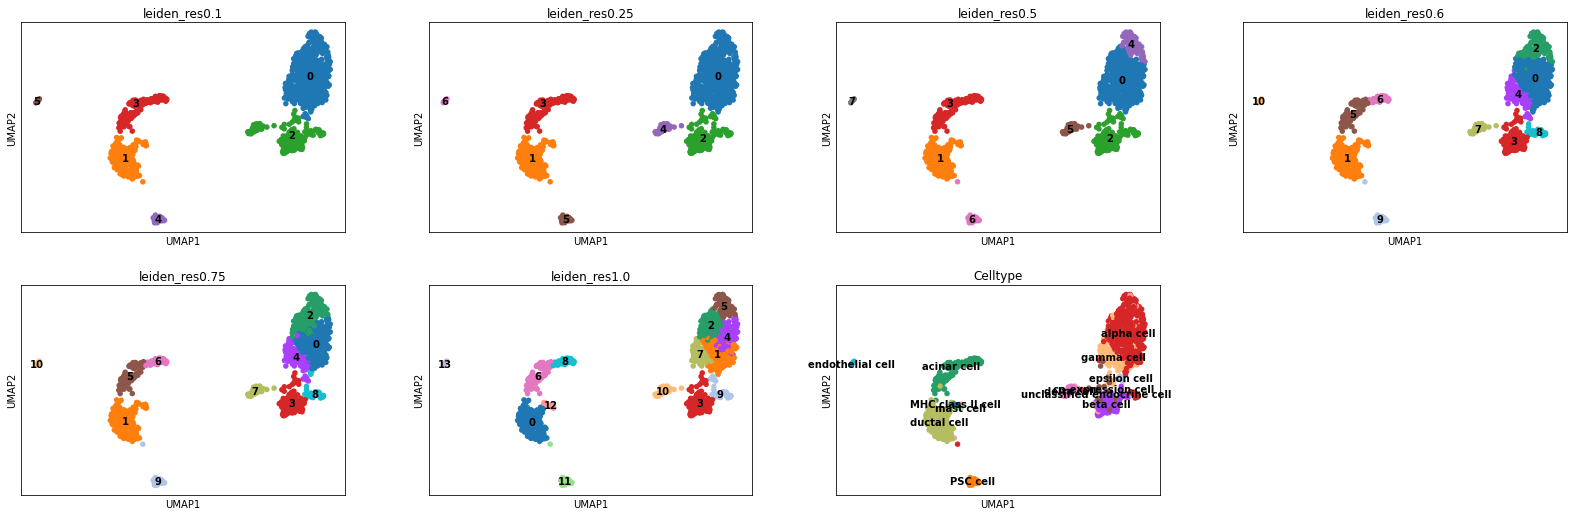

resolution: leiden_res0.1, ARI: 0.6536732879869384, V-measure: 0.7392558350807037, Silhouette score: 0.4680163064308414, Average: 0.6203151431661611
resolution: leiden_res0.25, ARI: 0.681593356609886, V-measure: 0.7690837663270869, Silhouette score: 0.4908806283670723, Average: 0.6471859171013484
resolution: leiden_res0.5, ARI: 0.5783066132457948, V-measure: 0.734391860074312, Silhouette score: 0.2884846484018809, Average: 0.5337277072406627
resolution: leiden_res0.6, ARI: 0.5975801269244186, V-measure: 0.7281545842262591, Silhouette score: 0.26120216746385977, Average: 0.5289789595381792
resolution: leiden_res0.75, ARI: 0.558903322810781, V-measure: 0.719017000626087, Silhouette score: 0.2605041986964225, Average: 0.5128081740444301
resolution: leiden_res1.0, ARI: 0.42512368886602814, V-measure: 0.673128222904865, Silhouette score: 0.24296921586327885, Average: 0.4470737092113906
Performing clustering with impute= True, recipe=seurat, harmony_pca=False


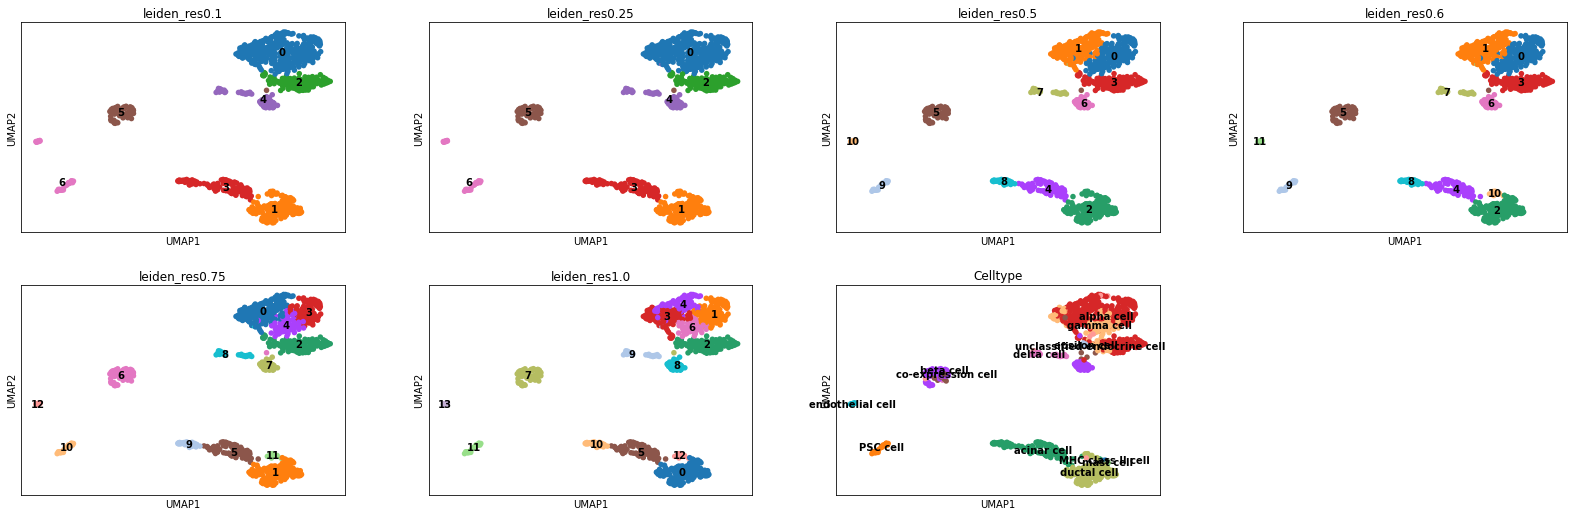

resolution: leiden_res0.1, ARI: 0.5709612888667337, V-measure: 0.7135585020972395, Silhouette score: 0.37754419550198187, Average: 0.554021328821985
resolution: leiden_res0.25, ARI: 0.570137332529172, V-measure: 0.7110863556276662, Silhouette score: 0.37935629448272284, Average: 0.5535266608798537
resolution: leiden_res0.5, ARI: 0.4565200002716355, V-measure: 0.6825679752173746, Silhouette score: 0.26491430460909604, Average: 0.468000760032702
resolution: leiden_res0.6, ARI: 0.44244801608133666, V-measure: 0.6761068717286829, Silhouette score: 0.24760564195645046, Average: 0.45538684325549
resolution: leiden_res0.75, ARI: 0.4687513588469001, V-measure: 0.6987583892002646, Silhouette score: 0.2252172435964187, Average: 0.4642423305478611
resolution: leiden_res1.0, ARI: 0.404025189425692, V-measure: 0.6617306859469049, Silhouette score: 0.22417892136405537, Average: 0.42997826557888413
Performing clustering with impute= True, recipe=zheng, harmony_pca=True


2023-04-26 01:38:17,874 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:38:18,193 - harmonypy - INFO - sklearn.KMeans initialization complete.


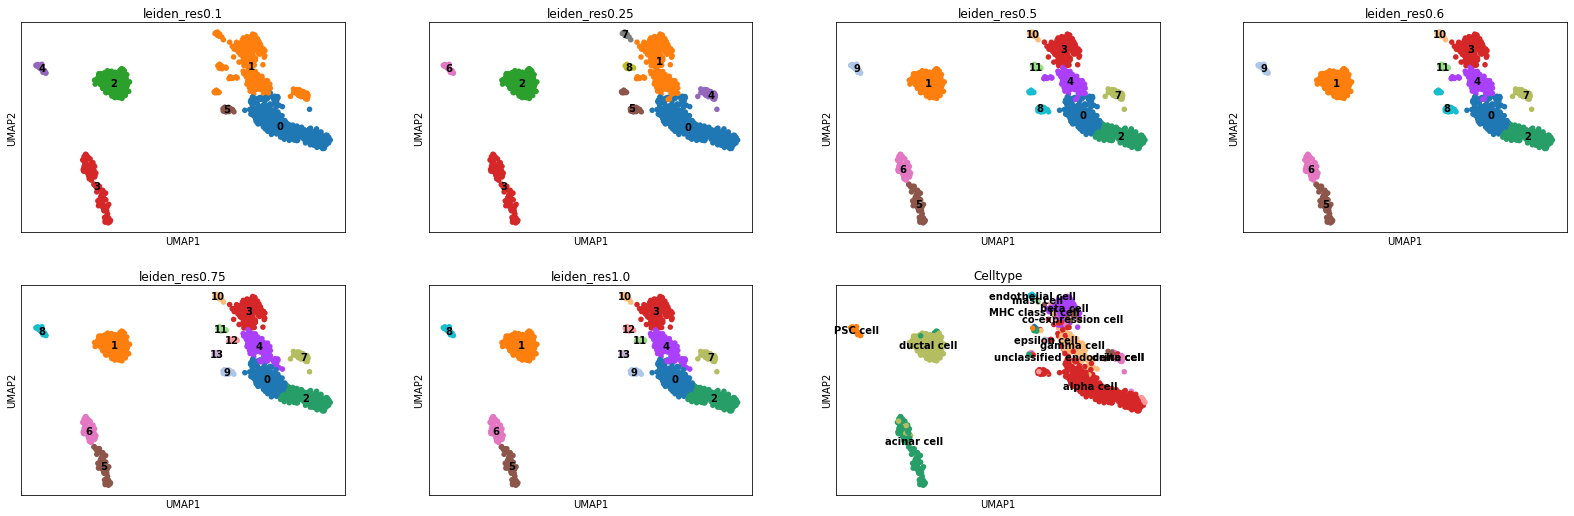

resolution: leiden_res0.1, ARI: 0.6204703221733167, V-measure: 0.673615736156511, Silhouette score: 0.2633401929793409, Average: 0.5191420837697228
resolution: leiden_res0.25, ARI: 0.6870553093988879, V-measure: 0.7164114888560803, Silhouette score: 0.2886879774272188, Average: 0.5640515918940624
resolution: leiden_res0.5, ARI: 0.5277988895314922, V-measure: 0.6866969835555368, Silhouette score: 0.24132196724783425, Average: 0.48527261344495437
resolution: leiden_res0.6, ARI: 0.5277988895314922, V-measure: 0.6866969835555368, Silhouette score: 0.24132196724783425, Average: 0.48527261344495437
resolution: leiden_res0.75, ARI: 0.551326264258375, V-measure: 0.7090388622810467, Silhouette score: 0.25642618699591063, Average: 0.5055971045117774
resolution: leiden_res1.0, ARI: 0.551326264258375, V-measure: 0.7090388622810465, Silhouette score: 0.25642618699591063, Average: 0.5055971045117774
Performing clustering with impute= True, recipe=zheng, harmony_pca=False


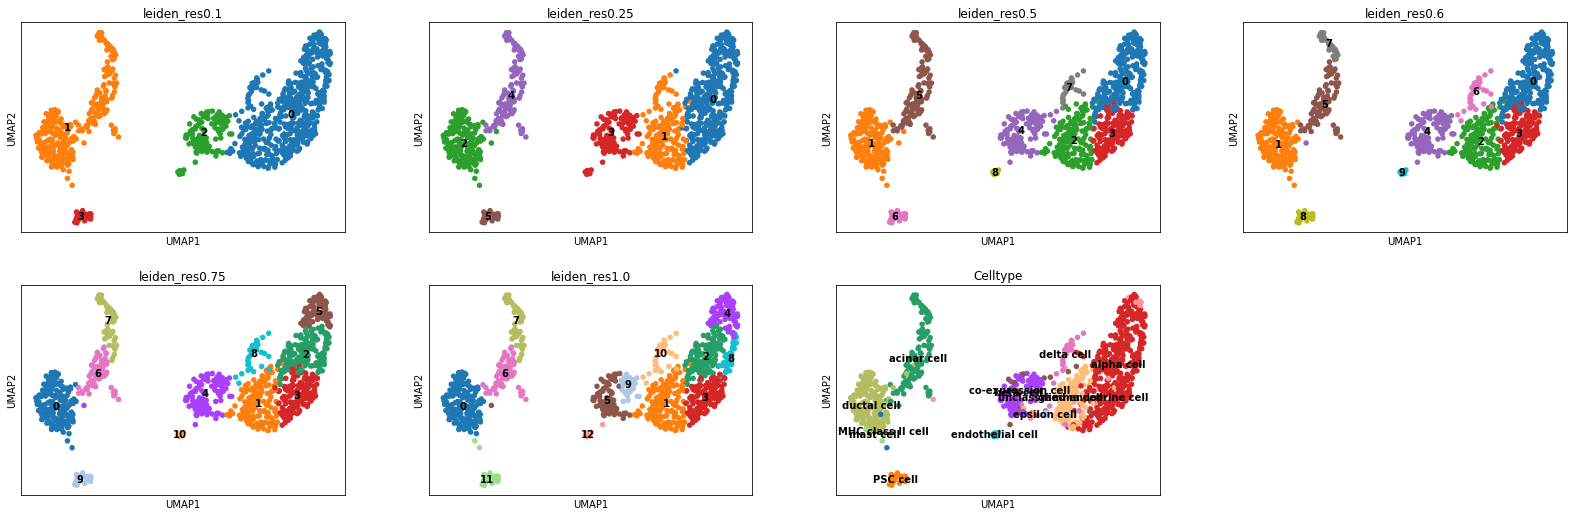

resolution: leiden_res0.1, ARI: 0.5558950840177308, V-measure: 0.6785632089226376, Silhouette score: 0.3298582675192851, Average: 0.5214388534865512
resolution: leiden_res0.25, ARI: 0.7898187471580496, V-measure: 0.7839494490264228, Silhouette score: 0.2592317206680444, Average: 0.6109999722841722
resolution: leiden_res0.5, ARI: 0.6177527952331685, V-measure: 0.7584706857982688, Silhouette score: 0.2057791473406295, Average: 0.5273342094573555
resolution: leiden_res0.6, ARI: 0.6059980622528436, V-measure: 0.7469777507045645, Silhouette score: 0.19736425536619087, Average: 0.516780022774533
resolution: leiden_res0.75, ARI: 0.5159785239134049, V-measure: 0.721409484962042, Silhouette score: 0.17393267200220683, Average: 0.4704402269592179
resolution: leiden_res1.0, ARI: 0.46148623513972603, V-measure: 0.6947167575755735, Silhouette score: 0.1584896344051902, Average: 0.4382308757068299
Performing clustering with impute= True, recipe=weinreb, harmony_pca=True


2023-04-26 01:38:27,586 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:38:27,981 - harmonypy - INFO - sklearn.KMeans initialization complete.


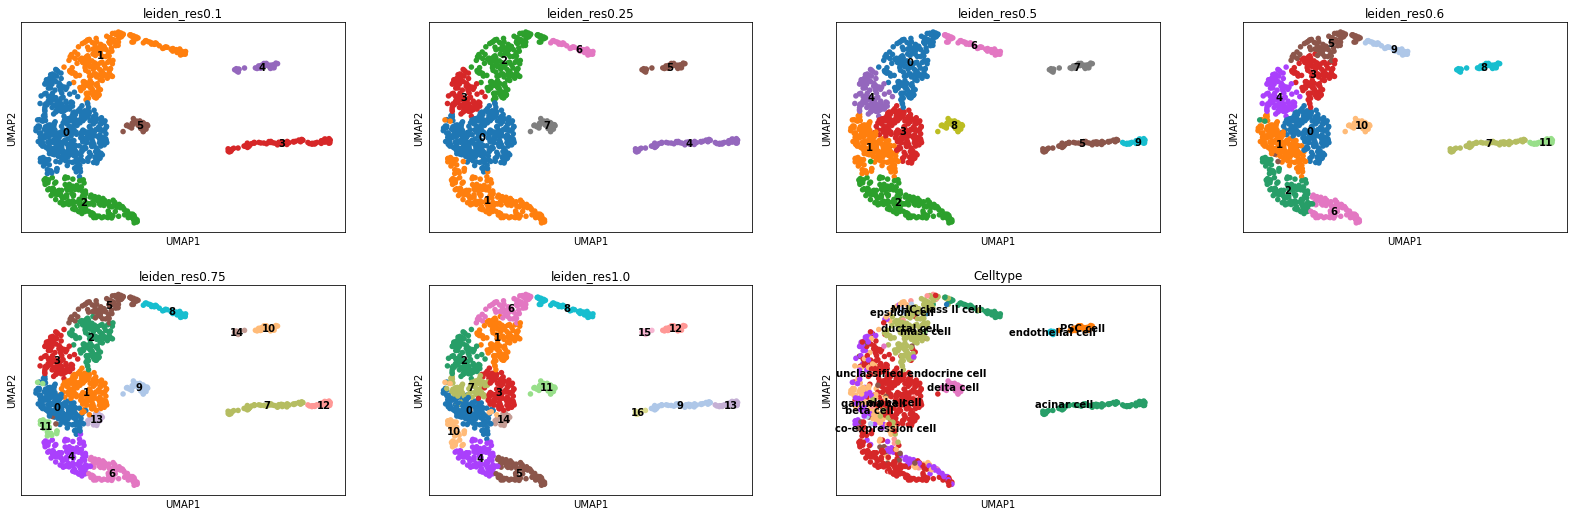

resolution: leiden_res0.1, ARI: 0.34146674973935787, V-measure: 0.49701902267727405, Silhouette score: 0.24685455538527737, Average: 0.36178010926730314
resolution: leiden_res0.25, ARI: 0.32622332614139854, V-measure: 0.5003545238903953, Silhouette score: 0.18765981220422415, Average: 0.3380792207453393
resolution: leiden_res0.5, ARI: 0.33905651192120784, V-measure: 0.5237704939182841, Silhouette score: 0.16585439337145305, Average: 0.3428937997369817
resolution: leiden_res0.6, ARI: 0.3060071871116764, V-measure: 0.5131392634976237, Silhouette score: 0.1696327848336866, Average: 0.32959307848099556
resolution: leiden_res0.75, ARI: 0.27345144955777806, V-measure: 0.5072700163346476, Silhouette score: 0.14876911848089475, Average: 0.30983019479110685
resolution: leiden_res1.0, ARI: 0.21706184025402678, V-measure: 0.47928934239400206, Silhouette score: 0.11149338049910609, Average: 0.26928152104904496
Performing clustering with impute= True, recipe=weinreb, harmony_pca=False


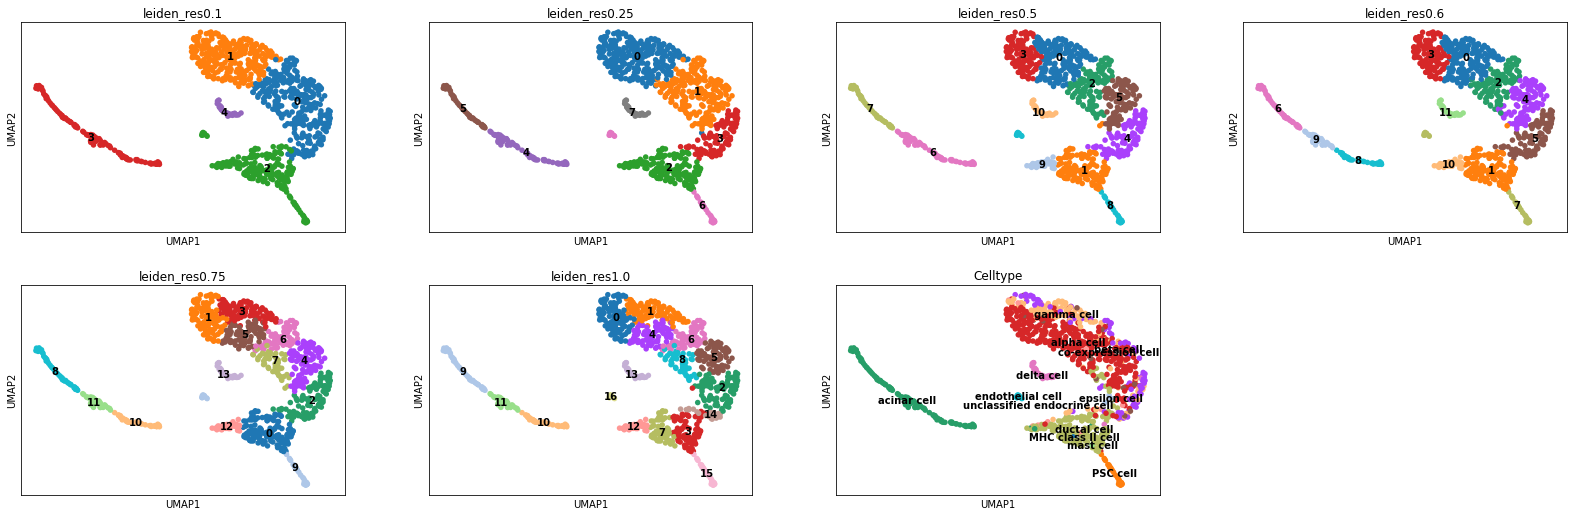

resolution: leiden_res0.1, ARI: 0.3441582585912391, V-measure: 0.5080425377436347, Silhouette score: 0.16683140310492656, Average: 0.3396773998132668
resolution: leiden_res0.25, ARI: 0.36541695463753254, V-measure: 0.5354733272118206, Silhouette score: 0.2596313824283258, Average: 0.38684055475922635
resolution: leiden_res0.5, ARI: 0.2646440184945361, V-measure: 0.48840286157960766, Silhouette score: 0.17987361618211284, Average: 0.3109734987520855
resolution: leiden_res0.6, ARI: 0.2550015600059477, V-measure: 0.4876241647651586, Silhouette score: 0.1719885570528594, Average: 0.30487142727465527
resolution: leiden_res0.75, ARI: 0.2509295099339176, V-measure: 0.49690390509958887, Silhouette score: 0.13710816074518178, Average: 0.29498052525956275
resolution: leiden_res1.0, ARI: 0.2204726870726251, V-measure: 0.501503799922981, Silhouette score: 0.13580265585442003, Average: 0.2859263809500087
Performing clustering with impute= True, recipe=basic, harmony_pca=True


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2023-04-26 01:38:38,833 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:38:39,156 - harmonypy - INFO - sklearn.KMeans initialization complete.


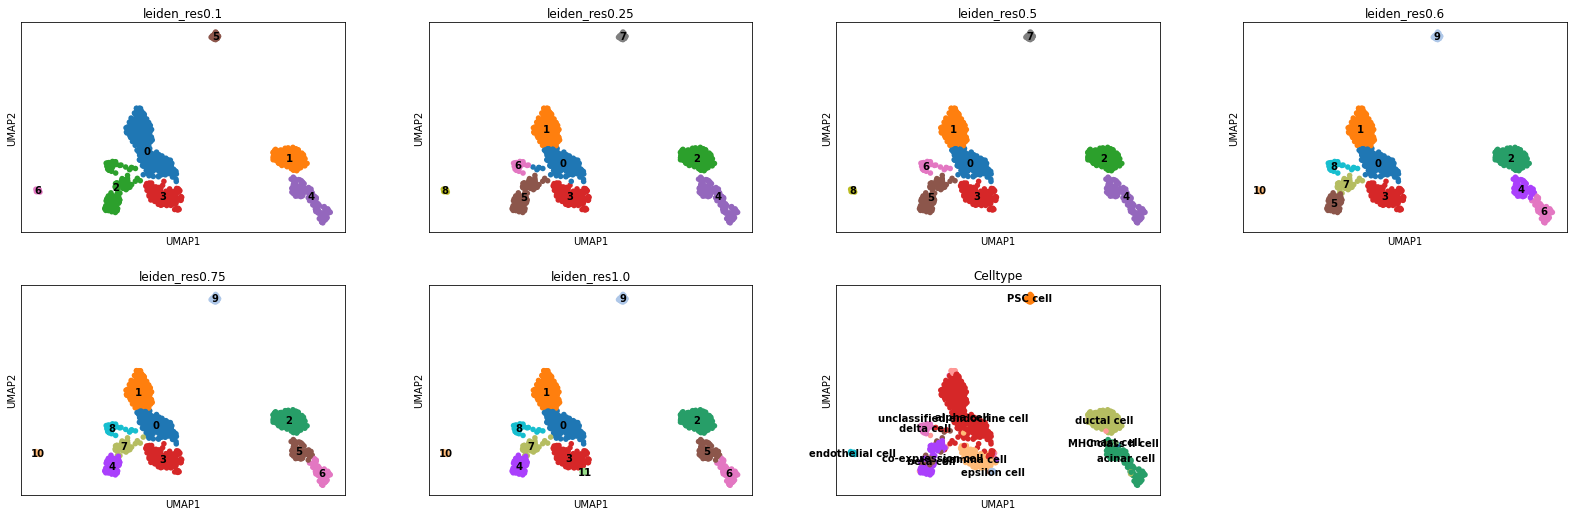

resolution: leiden_res0.1, ARI: 0.8414492563893538, V-measure: 0.8303227213213047, Silhouette score: 0.3677607803404124, Average: 0.6798442526836902
resolution: leiden_res0.25, ARI: 0.6533048783345724, V-measure: 0.7986478855509789, Silhouette score: 0.3322220552288481, Average: 0.5947249397047998
resolution: leiden_res0.5, ARI: 0.6478386399743609, V-measure: 0.7941978557154443, Silhouette score: 0.3298733079285715, Average: 0.5906366012061256
resolution: leiden_res0.6, ARI: 0.6098988323099058, V-measure: 0.765884198443955, Silhouette score: 0.33361664070211305, Average: 0.5697998904853246
resolution: leiden_res0.75, ARI: 0.6081041268739398, V-measure: 0.7646697257310302, Silhouette score: 0.3331697073599008, Average: 0.5686478533216236
resolution: leiden_res1.0, ARI: 0.6127529101203345, V-measure: 0.7725416779517089, Silhouette score: 0.3407693610498038, Average: 0.5753546497072825
Performing clustering with impute= True, recipe=basic, harmony_pca=False


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


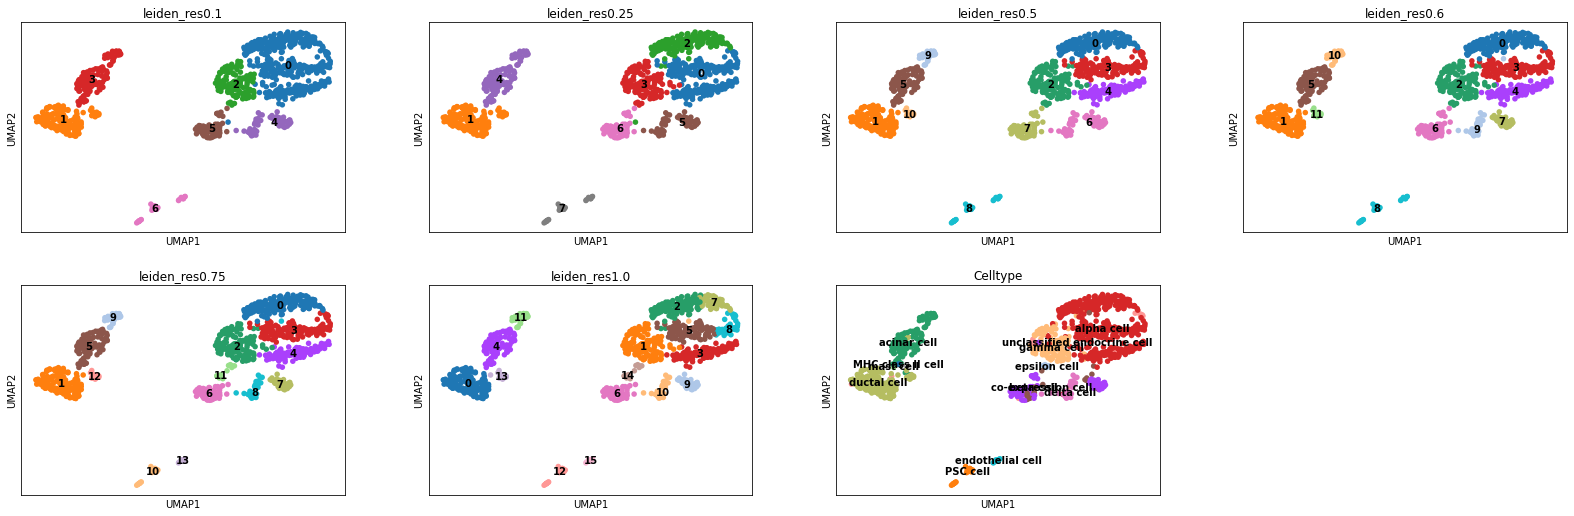

resolution: leiden_res0.1, ARI: 0.894356971705001, V-measure: 0.8504804133150058, Silhouette score: 0.3519011679956803, Average: 0.6989128510052289
resolution: leiden_res0.25, ARI: 0.6607478533272837, V-measure: 0.7854553145390263, Silhouette score: 0.2616173513601967, Average: 0.5692735064088356
resolution: leiden_res0.5, ARI: 0.5289391818416967, V-measure: 0.7396609566157789, Silhouette score: 0.2306804532810273, Average: 0.49976019724616766
resolution: leiden_res0.6, ARI: 0.534164809141527, V-measure: 0.7528321100645367, Silhouette score: 0.24769389368193961, Average: 0.511563604296001
resolution: leiden_res0.75, ARI: 0.5355705826595762, V-measure: 0.7576460716684487, Silhouette score: 0.2585356236444171, Average: 0.5172507593241473
resolution: leiden_res1.0, ARI: 0.45931815612618276, V-measure: 0.7290887186045264, Silhouette score: 0.23335156805405435, Average: 0.47391948092825453
Performing clustering with impute= True, recipe=None, harmony_pca=True


2023-04-26 01:38:50,335 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:38:51,027 - harmonypy - INFO - sklearn.KMeans initialization complete.


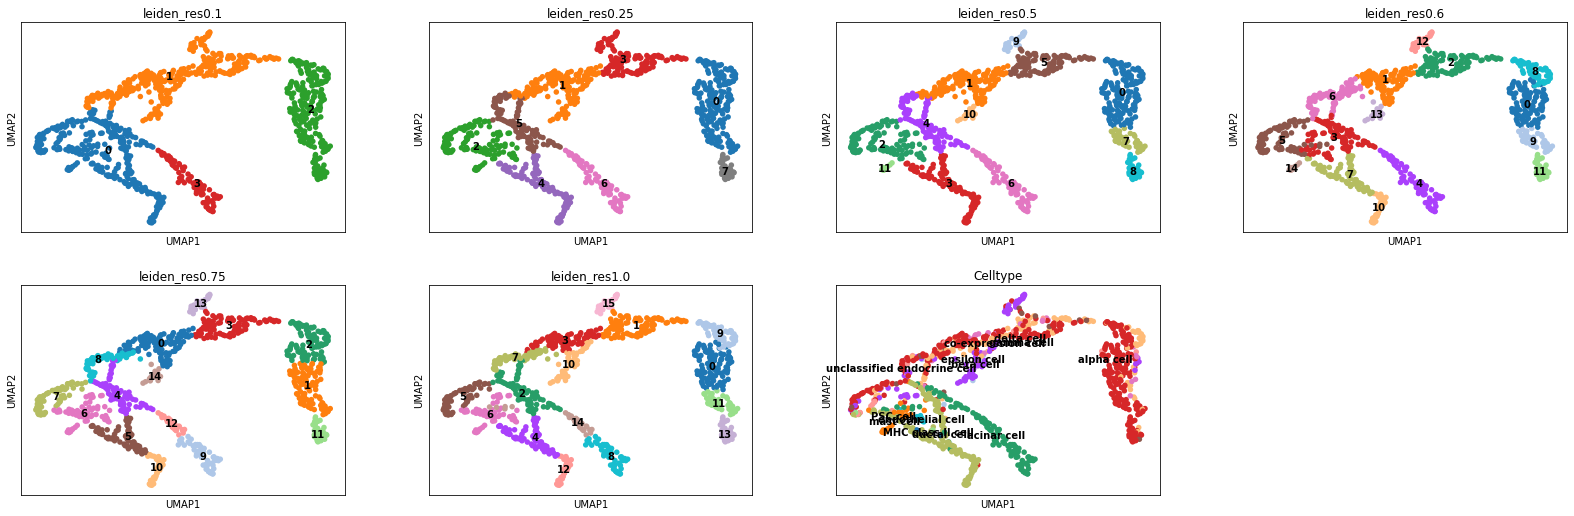

resolution: leiden_res0.1, ARI: 0.2526780972516376, V-measure: 0.39093988589272266, Silhouette score: 0.2562614060435967, Average: 0.29995979639598563
resolution: leiden_res0.25, ARI: 0.2404594998843677, V-measure: 0.3802576817865229, Silhouette score: 0.20708412106584184, Average: 0.2759337675789108
resolution: leiden_res0.5, ARI: 0.21693036498544963, V-measure: 0.40818370163558026, Silhouette score: 0.1993016019633141, Average: 0.274805222861448
resolution: leiden_res0.6, ARI: 0.18049467020297466, V-measure: 0.4134548553193622, Silhouette score: 0.2340224921185614, Average: 0.2759906725469661
resolution: leiden_res0.75, ARI: 0.17474554067613451, V-measure: 0.4155073734434702, Silhouette score: 0.23930360298806513, Average: 0.2765188390358899
resolution: leiden_res1.0, ARI: 0.17419501090439857, V-measure: 0.4270476575898915, Silhouette score: 0.22662506802900417, Average: 0.27595591217443144
Performing clustering with impute= True, recipe=None, harmony_pca=False


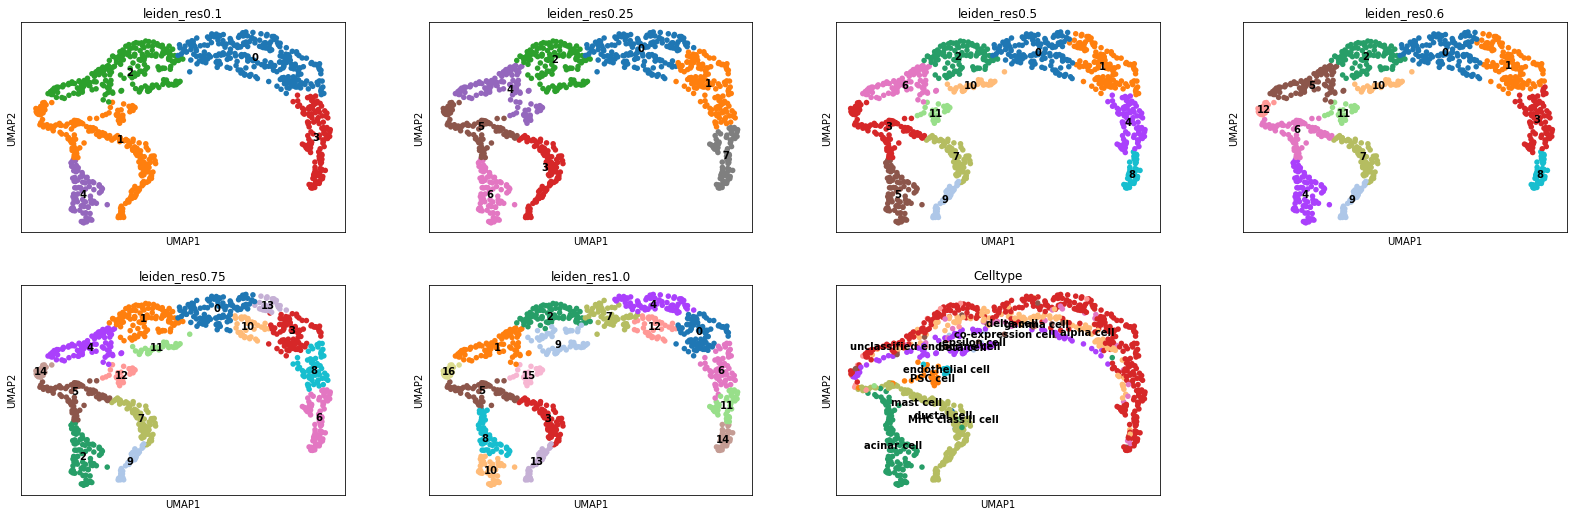

resolution: leiden_res0.1, ARI: 0.2883419000250813, V-measure: 0.4401765675172423, Silhouette score: 0.1742288457207652, Average: 0.30091577108769624
resolution: leiden_res0.25, ARI: 0.2418180419515254, V-measure: 0.42547999631037725, Silhouette score: 0.17971021294737935, Average: 0.2823360837364273
resolution: leiden_res0.5, ARI: 0.21191509292175076, V-measure: 0.44528872067631864, Silhouette score: 0.23014064964236491, Average: 0.2957814877468114
resolution: leiden_res0.6, ARI: 0.21851631375456387, V-measure: 0.46199097264627387, Silhouette score: 0.1869502997655102, Average: 0.28915252872211594
resolution: leiden_res0.75, ARI: 0.20621906667997478, V-measure: 0.4604035712270382, Silhouette score: 0.1400535925662167, Average: 0.26889207682440985
resolution: leiden_res1.0, ARI: 0.19464478182847908, V-measure: 0.47336541460141396, Silhouette score: 0.17957202953369006, Average: 0.2825274086545277
Performing clustering with impute= False, recipe=seurat, harmony_pca=True


2023-04-26 01:39:00,135 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:39:00,458 - harmonypy - INFO - sklearn.KMeans initialization complete.


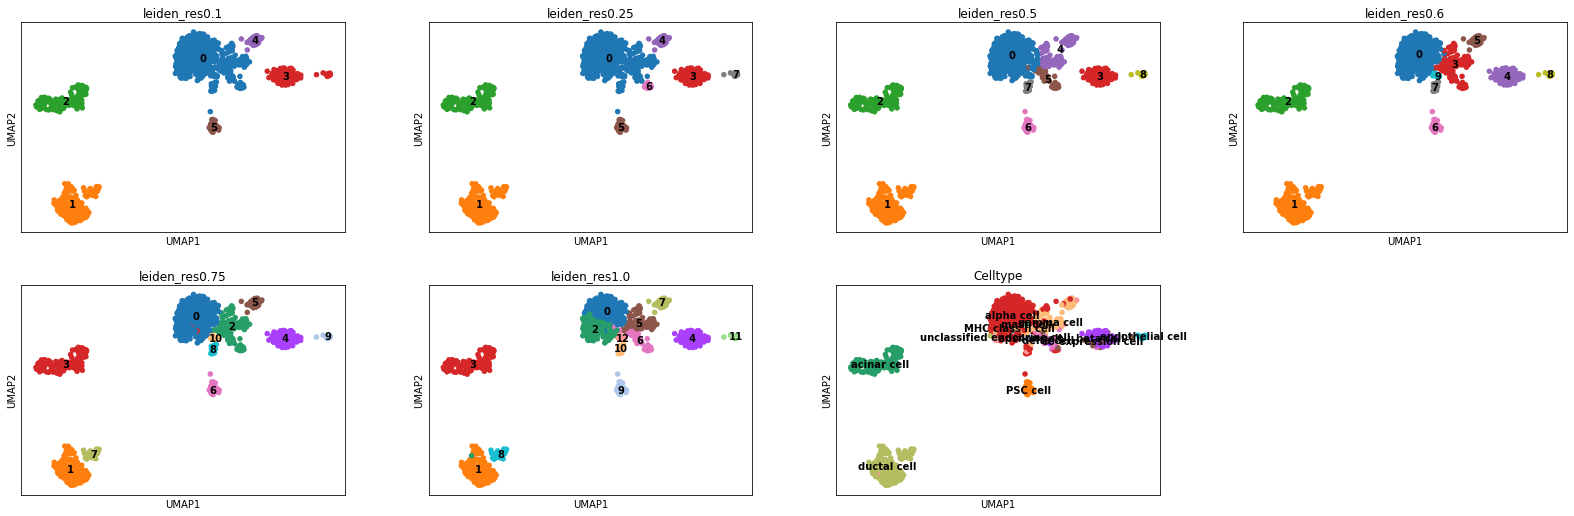

resolution: leiden_res0.1, ARI: 0.6480298098432387, V-measure: 0.7573133943958559, Silhouette score: 0.17475688716999402, Average: 0.5267000304696962
resolution: leiden_res0.25, ARI: 0.6712022694223311, V-measure: 0.7657643653229445, Silhouette score: 0.2043716134530073, Average: 0.5471127493994276
resolution: leiden_res0.5, ARI: 0.7615501323923813, V-measure: 0.7829412522864682, Silhouette score: 0.19426872646127358, Average: 0.5795867037133743
resolution: leiden_res0.6, ARI: 0.7770190526128459, V-measure: 0.7846720239280551, Silhouette score: 0.1950504430169957, Average: 0.5855805065192988
resolution: leiden_res0.75, ARI: 0.7599957036874453, V-measure: 0.7724697519717553, Silhouette score: 0.18780290644968367, Average: 0.573422787369628
resolution: leiden_res1.0, ARI: 0.5917511615002419, V-measure: 0.7308842038640732, Silhouette score: 0.14742750708810837, Average: 0.49002095748414115
Performing clustering with impute= False, recipe=seurat, harmony_pca=False


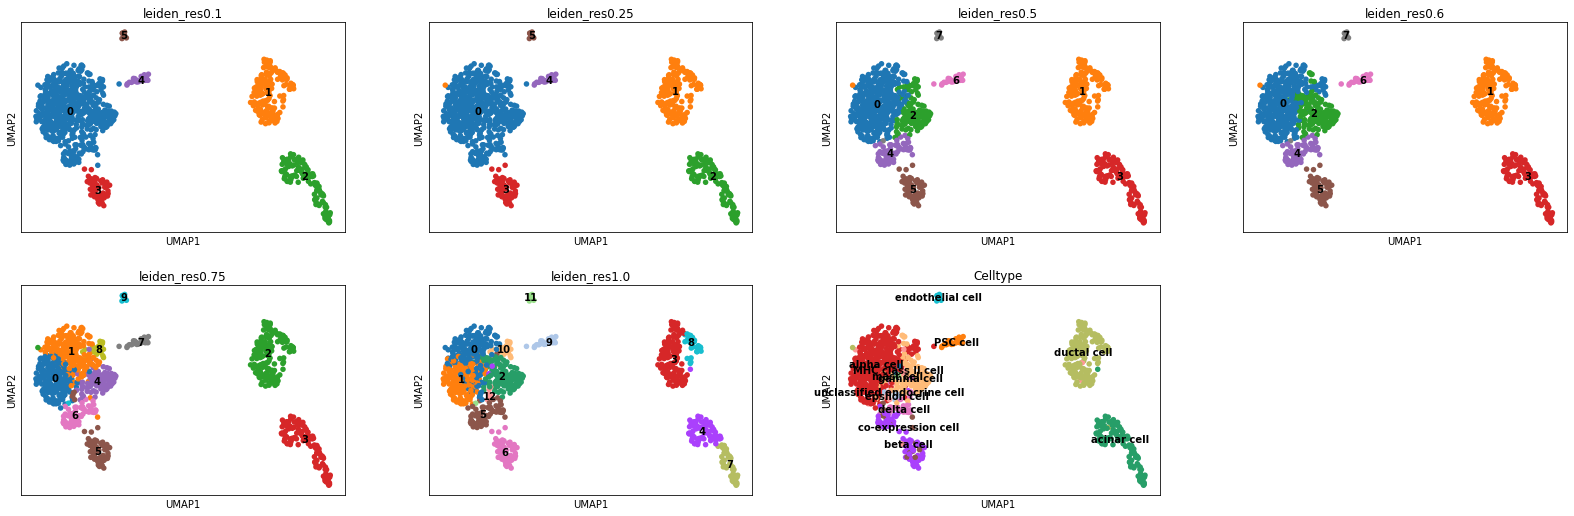

resolution: leiden_res0.1, ARI: 0.5275329862346436, V-measure: 0.7079002644600759, Silhouette score: 0.1917628189758257, Average: 0.4757320232235151
resolution: leiden_res0.25, ARI: 0.5322633512289053, V-measure: 0.7135642010537763, Silhouette score: 0.19220661860092836, Average: 0.47934472362787
resolution: leiden_res0.5, ARI: 0.7702419686806447, V-measure: 0.7771943286054078, Silhouette score: 0.16423921347021725, Average: 0.5705585035854233
resolution: leiden_res0.6, ARI: 0.8049055931969108, V-measure: 0.7957453256109511, Silhouette score: 0.15949221575814537, Average: 0.5867143781886691
resolution: leiden_res0.75, ARI: 0.5944708681829123, V-measure: 0.7383120771905408, Silhouette score: 0.11271646376885454, Average: 0.48183313638076924
resolution: leiden_res1.0, ARI: 0.5013829884050992, V-measure: 0.6954448549770283, Silhouette score: 0.08324663796702811, Average: 0.4266914937830519
Performing clustering with impute= False, recipe=zheng, harmony_pca=True


2023-04-26 01:39:08,302 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:39:08,596 - harmonypy - INFO - sklearn.KMeans initialization complete.


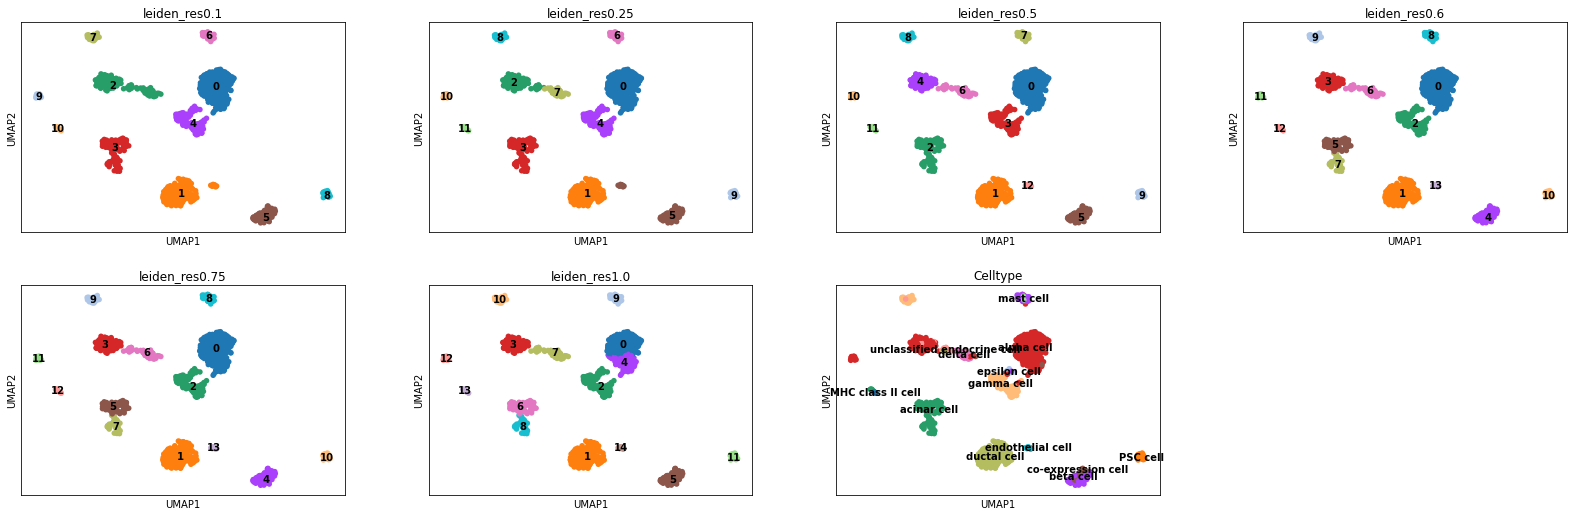

resolution: leiden_res0.1, ARI: 0.6552371590606363, V-measure: 0.7779396252154529, Silhouette score: 0.34002099032787175, Average: 0.5910659248679869
resolution: leiden_res0.25, ARI: 0.6780235977941211, V-measure: 0.7984634749271912, Silhouette score: 0.3508108608698974, Average: 0.6090993111970698
resolution: leiden_res0.5, ARI: 0.6855950829605001, V-measure: 0.8074409998124314, Silhouette score: 0.3826532774265729, Average: 0.6252297867331682
resolution: leiden_res0.6, ARI: 0.6633178373463681, V-measure: 0.7933906702956337, Silhouette score: 0.36807883800297875, Average: 0.6082624485483268
resolution: leiden_res0.75, ARI: 0.6633178373463681, V-measure: 0.7933906702956337, Silhouette score: 0.36807883800297875, Average: 0.6082624485483268
resolution: leiden_res1.0, ARI: 0.532380673236358, V-measure: 0.7630485984703809, Silhouette score: 0.28181542618342637, Average: 0.525748232630055
Performing clustering with impute= False, recipe=zheng, harmony_pca=False


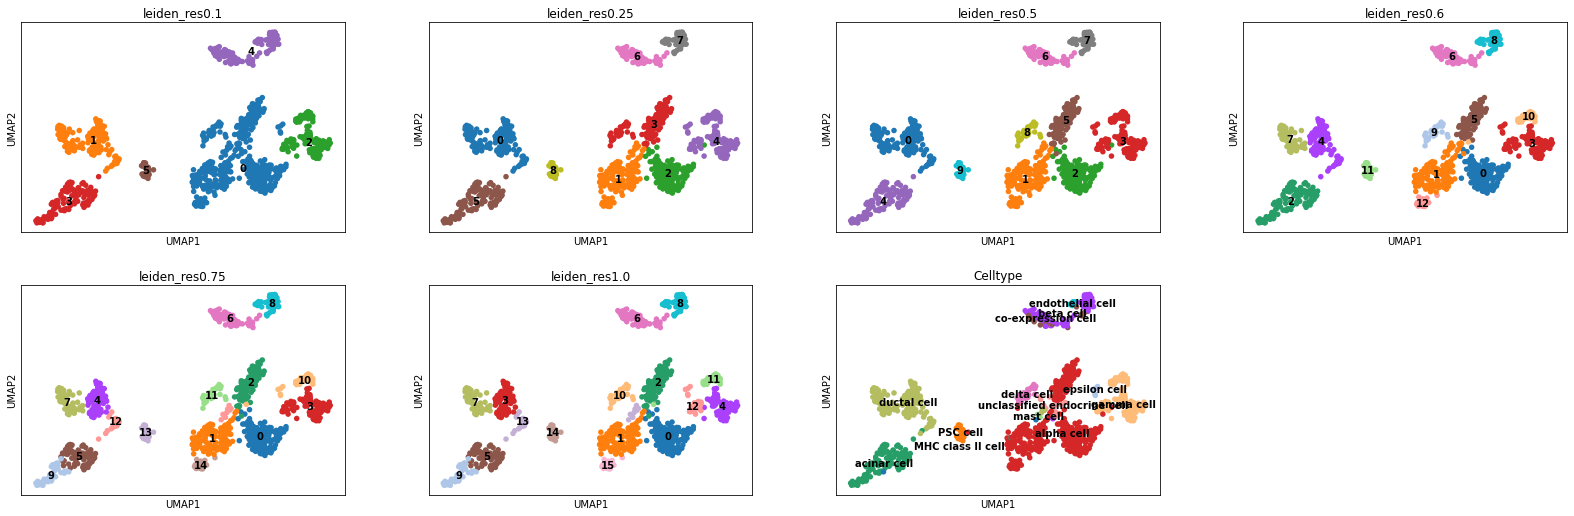

resolution: leiden_res0.1, ARI: 0.8446280703994413, V-measure: 0.8771823569739196, Silhouette score: 0.19192436103758873, Average: 0.6379115961369831
resolution: leiden_res0.25, ARI: 0.5828237604381045, V-measure: 0.7874505740186432, Silhouette score: 0.1770105850591621, Average: 0.5157616398386365
resolution: leiden_res0.5, ARI: 0.5987985524730314, V-measure: 0.8040372067371305, Silhouette score: 0.18272098839657275, Average: 0.5285189158689115
resolution: leiden_res0.6, ARI: 0.48861542222034726, V-measure: 0.7525073455382818, Silhouette score: 0.13352401541739228, Average: 0.45821559439200704
resolution: leiden_res0.75, ARI: 0.45105711501384754, V-measure: 0.7430046307078867, Silhouette score: 0.16119143072864073, Average: 0.4517510588167917
resolution: leiden_res1.0, ARI: 0.4344565374848956, V-measure: 0.734199426399471, Silhouette score: 0.16120891947018126, Average: 0.44328829445151596
Performing clustering with impute= False, recipe=weinreb, harmony_pca=True


2023-04-26 01:39:21,580 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:39:21,844 - harmonypy - INFO - sklearn.KMeans initialization complete.


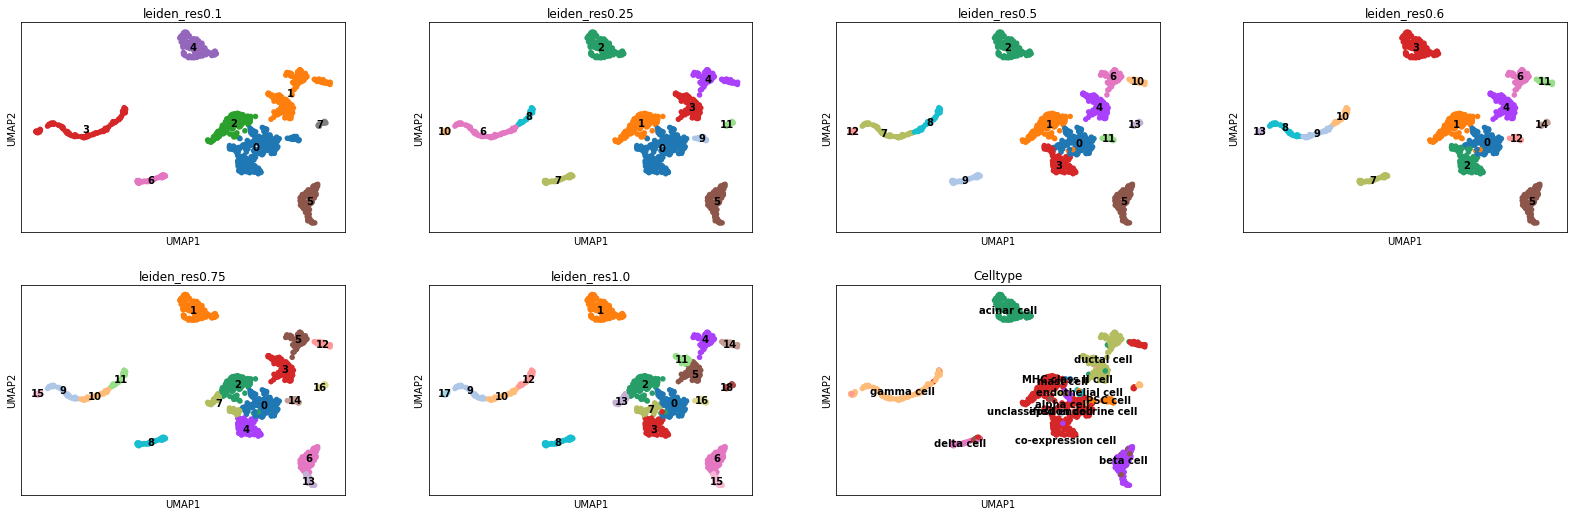

resolution: leiden_res0.1, ARI: 0.5732584202829956, V-measure: 0.7193759153088763, Silhouette score: 0.21598084281350288, Average: 0.5028717261351249
resolution: leiden_res0.25, ARI: 0.5356418436959449, V-measure: 0.7080601067528015, Silhouette score: 0.21316193532625113, Average: 0.48562129525833253
resolution: leiden_res0.5, ARI: 0.44349350581001673, V-measure: 0.699001065391272, Silhouette score: 0.12049390596030954, Average: 0.42099615905386617
resolution: leiden_res0.6, ARI: 0.4358617859341113, V-measure: 0.6942115478408128, Silhouette score: 0.13063069678877265, Average: 0.42023467685456556
resolution: leiden_res0.75, ARI: 0.38882473435950066, V-measure: 0.6742867179459128, Silhouette score: 0.12785393241677218, Average: 0.3969884615740619
resolution: leiden_res1.0, ARI: 0.35311943570016463, V-measure: 0.6620606089454689, Silhouette score: 0.1634067949569854, Average: 0.3928622798675397
Performing clustering with impute= False, recipe=weinreb, harmony_pca=False


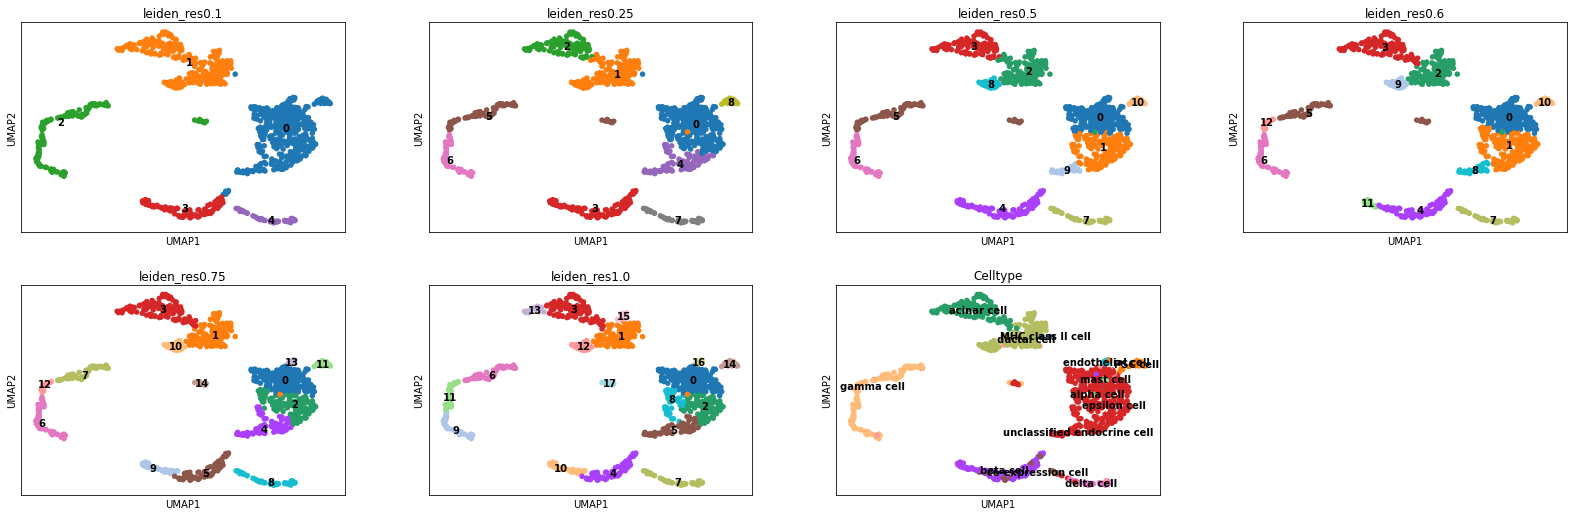

resolution: leiden_res0.1, ARI: 0.7164787647154326, V-measure: 0.7549000873523152, Silhouette score: 0.2585856495915327, Average: 0.5766548338864268
resolution: leiden_res0.25, ARI: 0.6710108455436882, V-measure: 0.7762411243405386, Silhouette score: 0.18543764915789868, Average: 0.5442298730140418
resolution: leiden_res0.5, ARI: 0.5482770480535217, V-measure: 0.7432002126707802, Silhouette score: 0.12143752310435321, Average: 0.4709715946095517
resolution: leiden_res0.6, ARI: 0.545593719482081, V-measure: 0.7450689656403967, Silhouette score: 0.11089753128843145, Average: 0.46718673880363637
resolution: leiden_res0.75, ARI: 0.5178225171078515, V-measure: 0.7432700646580181, Silhouette score: 0.10790130541243313, Average: 0.456331295726101
resolution: leiden_res1.0, ARI: 0.4499582654192072, V-measure: 0.7140555320602135, Silhouette score: 0.16015756073837512, Average: 0.4413904527392653
Performing clustering with impute= False, recipe=basic, harmony_pca=True


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2023-04-26 01:39:35,085 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:39:35,562 - harmonypy - INFO - sklearn.KMeans initialization complete.


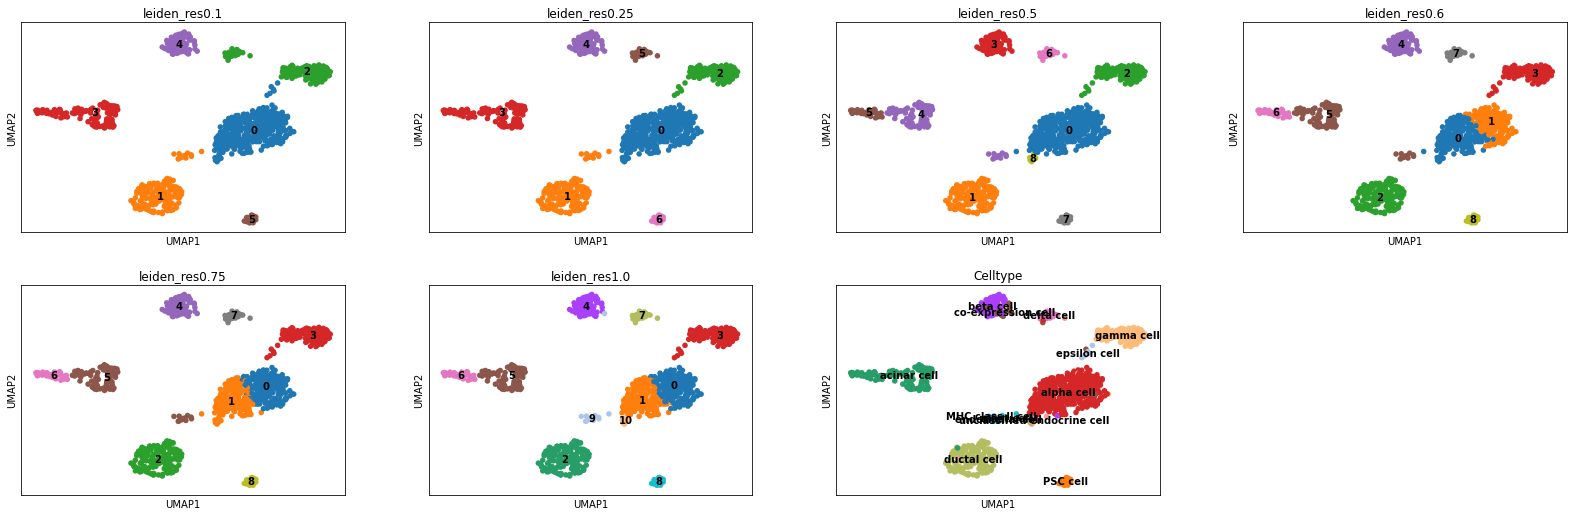

resolution: leiden_res0.1, ARI: 0.8922531989480774, V-measure: 0.881885422040597, Silhouette score: 0.2744758508354756, Average: 0.6828714906080501
resolution: leiden_res0.25, ARI: 0.9233054243767852, V-measure: 0.9092693733384976, Silhouette score: 0.2901563017875473, Average: 0.7075770331676101
resolution: leiden_res0.5, ARI: 0.9356306482026802, V-measure: 0.9037067944790675, Silhouette score: 0.28127507212432906, Average: 0.7068708382686922
resolution: leiden_res0.6, ARI: 0.6738508123262021, V-measure: 0.8296945800811119, Silhouette score: 0.15911787247325496, Average: 0.554221088293523
resolution: leiden_res0.75, ARI: 0.6825734326471977, V-measure: 0.8313465188396917, Silhouette score: 0.1630075252757931, Average: 0.5589758255875608
resolution: leiden_res1.0, ARI: 0.6951137817125805, V-measure: 0.8547788926817288, Silhouette score: 0.1691266829046345, Average: 0.5730064524329813
Performing clustering with impute= False, recipe=basic, harmony_pca=False


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


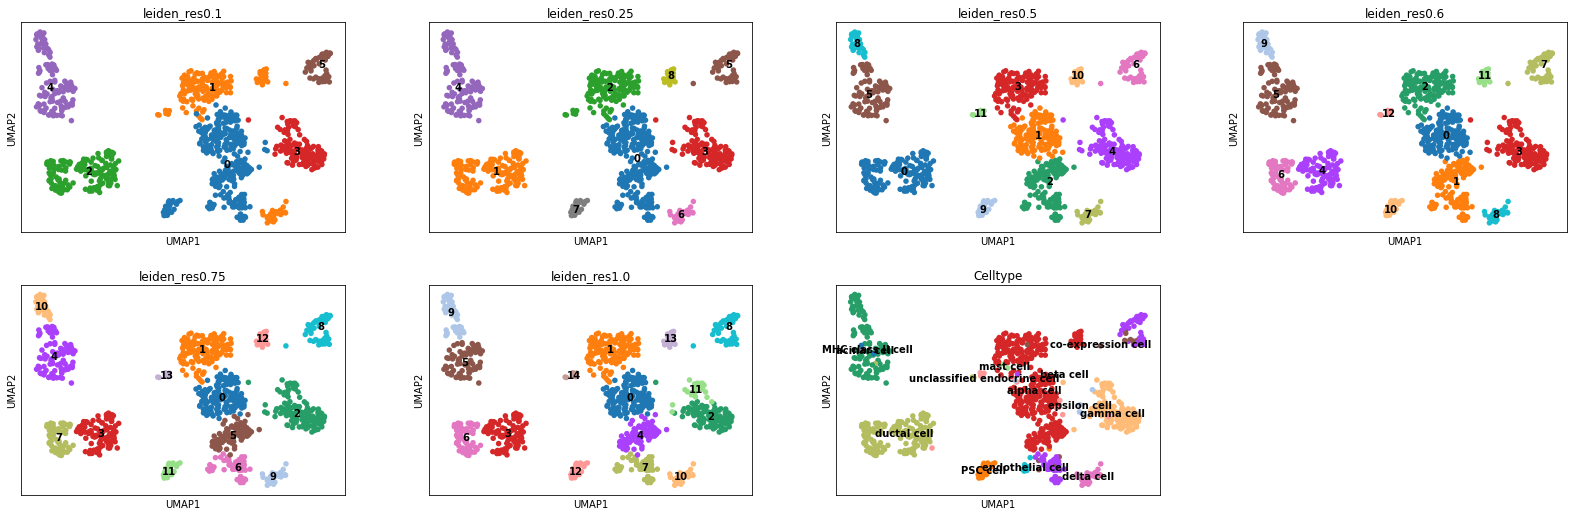

resolution: leiden_res0.1, ARI: 0.559675564862977, V-measure: 0.7277871597397929, Silhouette score: 0.1390139507847764, Average: 0.47549222512918216
resolution: leiden_res0.25, ARI: 0.5986237408576324, V-measure: 0.7730454231554896, Silhouette score: 0.08385065666033988, Average: 0.48517327355782064
resolution: leiden_res0.5, ARI: 0.5312147861195015, V-measure: 0.7556668890975512, Silhouette score: 0.10966983526464019, Average: 0.46551717016056426
resolution: leiden_res0.6, ARI: 0.4759502785462882, V-measure: 0.736381893949976, Silhouette score: 0.09271433566672438, Average: 0.43501550272099615
resolution: leiden_res0.75, ARI: 0.5021041158514206, V-measure: 0.7638271675367169, Silhouette score: 0.11575131693540033, Average: 0.46056086677451263
resolution: leiden_res1.0, ARI: 0.47359708349048224, V-measure: 0.7514150662241309, Silhouette score: 0.12485929650406571, Average: 0.44995714873955966
Performing clustering with impute= False, recipe=None, harmony_pca=True


2023-04-26 01:39:46,357 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-26 01:39:46,813 - harmonypy - INFO - sklearn.KMeans initialization complete.


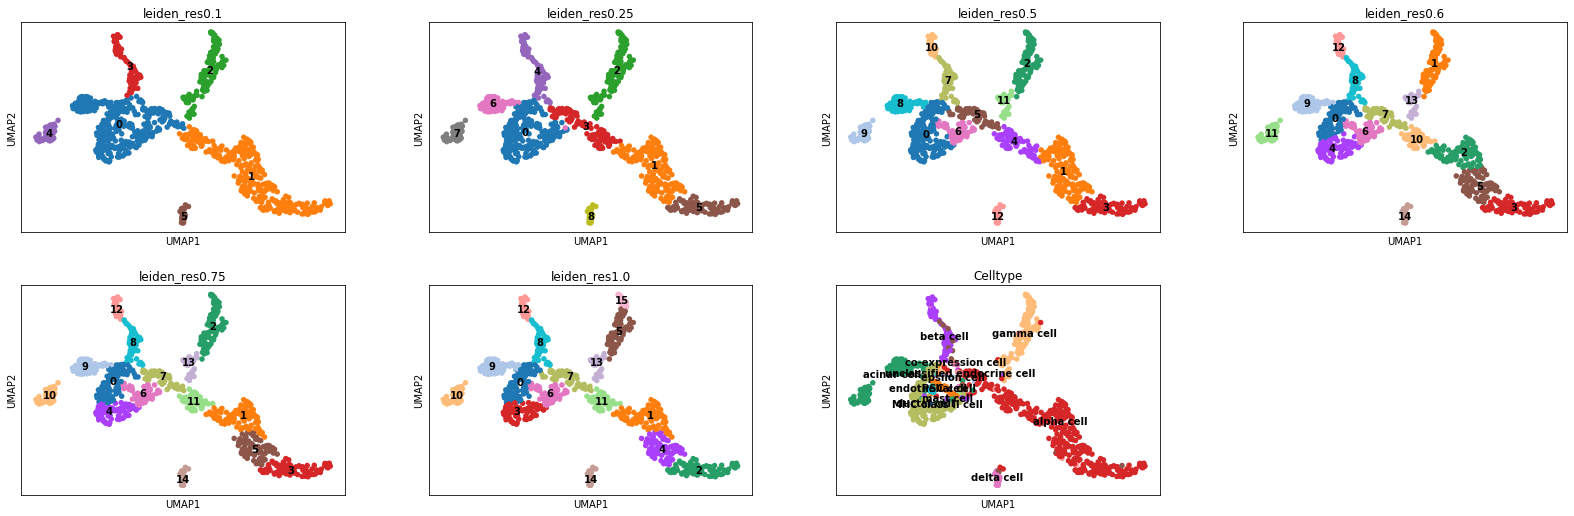

resolution: leiden_res0.1, ARI: 0.5315086704440629, V-measure: 0.6377494345190997, Silhouette score: 0.21760019094209032, Average: 0.46228609863508435
resolution: leiden_res0.25, ARI: 0.47623279692846743, V-measure: 0.6685065003199236, Silhouette score: 0.1462727813072649, Average: 0.430337359518552
resolution: leiden_res0.5, ARI: 0.4243643133984359, V-measure: 0.6426020063060419, Silhouette score: 0.16034628695115083, Average: 0.40910420221854293
resolution: leiden_res0.6, ARI: 0.33355032651936045, V-measure: 0.619026922015387, Silhouette score: 0.12723405330994353, Average: 0.359937100614897
resolution: leiden_res0.75, ARI: 0.3341743262141013, V-measure: 0.6211787820412517, Silhouette score: 0.1252863375804204, Average: 0.36021314861192444
resolution: leiden_res1.0, ARI: 0.31872101482866355, V-measure: 0.6165871675773084, Silhouette score: 0.1375701832881337, Average: 0.3576261218980352
Performing clustering with impute= False, recipe=None, harmony_pca=False


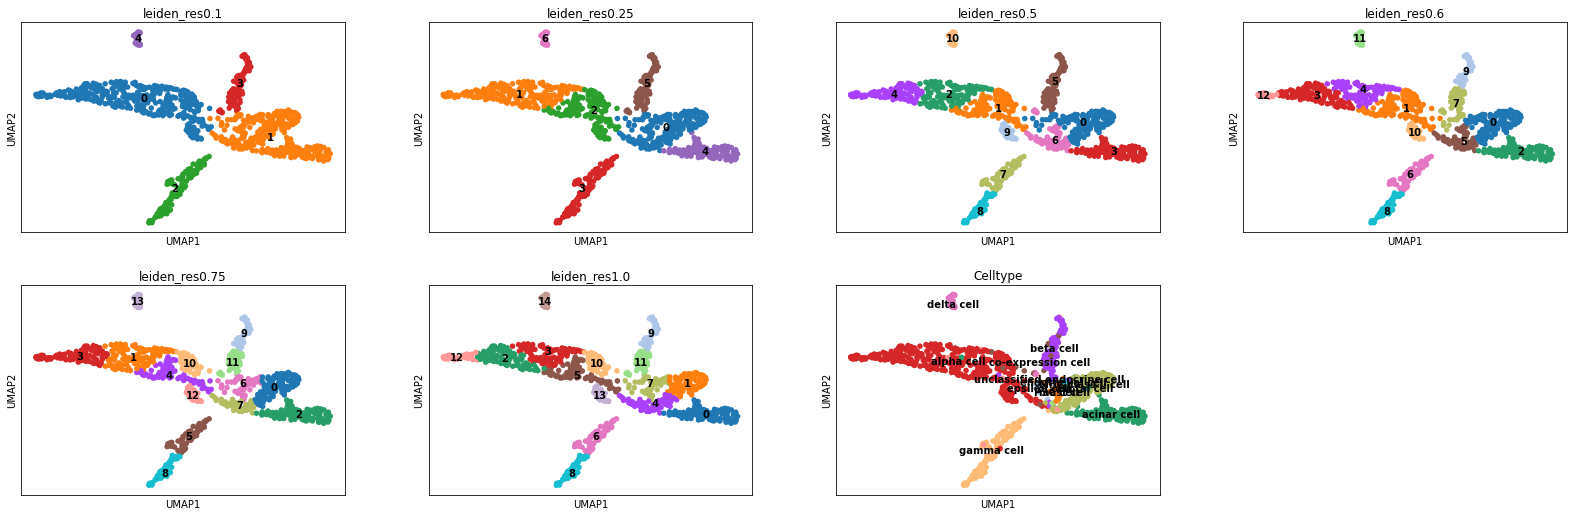

resolution: leiden_res0.1, ARI: 0.6928060629775122, V-measure: 0.7200536270518141, Silhouette score: 0.08456261377526439, Average: 0.49914076793486356
resolution: leiden_res0.25, ARI: 0.602502850746839, V-measure: 0.7395689873630777, Silhouette score: 0.08831972949194435, Average: 0.4767971892006204
resolution: leiden_res0.5, ARI: 0.45605116539880436, V-measure: 0.6780730785767979, Silhouette score: -0.01061889215273866, Average: 0.37450178394095457
resolution: leiden_res0.6, ARI: 0.43694662896958714, V-measure: 0.6736137627854528, Silhouette score: 0.03344873015187756, Average: 0.3813363739689725
resolution: leiden_res0.75, ARI: 0.42572750887430455, V-measure: 0.6770874059530795, Silhouette score: 7.569544581643673e-05, Average: 0.36763020342440017
resolution: leiden_res1.0, ARI: 0.37057836227859725, V-measure: 0.6587154360653975, Silhouette score: 0.05597085052861141, Average: 0.3617548829575354


In [112]:
# Adjust these lists according to the parameters you want to test
imputed = [True, False]
recipe_list = ['seurat', 'zheng', 'weinreb', 'basic', 'None']
harmony_pca_list = [True, False]
leiden_resolution_list = [0.1, 0.25, 0.5, 0.6, 0.75, 1.0]
umap = True

results = []
maxavg = 0

# Iterate over all combinations of parameters and perform clustering
for impute in imputed:
    if impute:
        adata = sc.AnnData(sc_pancreas_imputed.T)
    else:
        adata = sc.AnnData(sc_pancreas.T)
    for recipe in recipe_list:
        for harmony_pca in harmony_pca_list:
                print(f'Performing clustering with impute= {impute}, recipe={recipe}, harmony_pca={harmony_pca}')
                adata_result = perform_clustering(adata, use_recipe=recipe,
                                            use_harmony_pca=harmony_pca, leiden_resolution=leiden_resolution_list,
                                            sc_pancreas_metadata= sc_pancreas_metadata)
                result = {
                    'adata': adata_result,
                    'seurat_recipe': recipe,
                    'harmony_pca': harmony_pca
                }
                results.append(result)

                if umap:
                    sc.pl.umap(
                    adata_result,
                    color=["leiden_res0.1", "leiden_res0.25", "leiden_res0.5", "leiden_res0.6", "leiden_res0.75", "leiden_res1.0", "Celltype"],
                    legend_loc="on data",
                    )
                # calculate scores for each leiden resolution
                for lr in leiden_resolution_list:
                    leiden_key = 'leiden_res' + str(lr)
                    avg = cluster_scoring(adata_result, leiden_key, sc_pancreas_metadata)
                    if avg > maxavg:
                        maxavg = avg
                        maxadata = adata_result
                        maxrecipe = recipe
                        maxharmony_pca = harmony_pca
                        maxleiden_key = leiden_key
                    

# `results` will now contain the clustering results for all combinations of methods


# Step 3: Predict on the test data

Performing imputation to create imputed_bulkified.csv

In [36]:
sc_pancreas_imputed_test = magic_operator.transform(sc_pancreas_test)                        
bulkified = bulkification(sc_pancreas_imputed_test)
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
bulkified.columns = ["patient5","patient6","patient7"]
bulkified.index = sc_pancreas_test.index

Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 1.15 seconds.


### Perform clustering to assign cell cluster membership 

### Perform PCA to coordinates of the cells in the test dataset in the 50 first PCs computed on your data

# Step 4: Save the required files

In [ ]:
results_path = os.getcwd()
archive_name = "Jung_HuiJeong_Project2.zip" # TODO

In [ ]:
assert all(bulkified.columns == ["index","patient5","patient6","patient7"])

In [ ]:
assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
assert all(cluster_labels.columns == ["index","cluster"])

In [ ]:
assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])

In [ ]:
assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
    with zf.open(f"imputed_bulkified.csv", "w") as buffer:
        bulkified.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    with zf.open(f"PCA.csv", "w") as buffer:
        PCA.to_csv(buffer)
    zf.close()

In [ ]:
archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
assert all(
        [
            i in archive.namelist()
            for i in [
                "imputed_bulkified.csv",
                "cluster_membership.csv",
                "PCA.csv",
            ]
        ]
    )